
# MASTER PROJECT

**Identification and Exploration of Extreme Weather Events From Twitter Data**

*by Julie Maria Petersen and Lise Styve*

This explainer notebook consists of the code used in the M.Sc. thesis project "Identification and Exploration of Extreme Weather Events From Twitter Data" prepared at the Department of Applied Mathematics and Computer Science at the Technical University of Denmark (DTU) during the Spring 2021. The thesis was completed as a part of the research project [AI for Climate Adaptation](https://liu.se/en/research/ai4climateadaptation) at Linköping University (LiU) under supervision by Sune Lehmann from DTU and Katerina Vrotsou from LiU. 

The objective of the thesis was to implement methods to identify and visually explore extreme weather events, particularly floods, from Twitter data. To this end, the main tasks for the project were to implement text data mining methods for identification of relevant events from Twitter data and to create an accompanying [visual interface](https://extremeweatherdetection.herokuapp.com/) for exploring the events.

**Project pipeline:**

1. Data collection
2. Text classification
3. Location Extracion
4. Data visualisation

Labelled data
* Build classifiers
* Build location extraction algorithm 
* Build Visualisation

Unlabelled data
* Use classifiers
* Use algorithm location extraction algorithm 
* Use visualisation to explore and evaluate

The classifiers are build based on a labelled data set from [CrisisLex](https://crisislex.org/data-collections.html#CrisisLexT6) and with the use cases:

1. [Alberta floods](https://en.wikipedia.org/wiki/2013_Alberta_floods)
2. [Queensland floods](https://en.wikipedia.org/wiki/Cyclone_Oswald)

The classifiers are build in three different categories within machine learning: classic machine learning algorithms, deep learning and transfer learning. After this follows the design of a location extraction algorithm for locating the tweets in order to map them. 

The performance for each classifier is evaluated and then used for classifying tweets from the unlabelled data set collected that was also used to build the [Global Flood Monitor](https://www.globalfloodmonitor.org/). We filtered out a subset of English tweets in the period 2016-2018.


**OBS: Parts of the notebook should be run in Google Colab to take advantage of GPU**

# Data load and pre-processing

## Libraries and packages

In [ ]:
from __future__ import division, print_function
import pandas as pd
import numpy as np
import os 
import json
import math
import random
import string 
import itertools
import requests
import re
import ast 
from ast import literal_eval
import urllib.request
from urllib.request import urlopen
import pathlib
import textwrap
import copy
import calendar
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

#!pip install fastai==1.0.61
from fastai.text import *

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk import word_tokenize
import collections
import spacy
#nltk.download('stopwords')
#nltk.download('wordnet')
#!python -m spacy download en_core_web_lg
#from gensim import models

# scikit learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# keras
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, SimpleRNN
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.backend import clear_session
from keras.models import model_from_json
from keras_preprocessing.text import tokenizer_from_json

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import color_palette
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# mapping
#!pip install geograpy3
#import geograpy
import folium
from folium import FeatureGroup, LayerControl, plugins, Map, Marker
from folium.plugins import FastMarkerCluster, MarkerCluster
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

# dash
import dash
import dash_table
import dash_core_components as dcc
import dash_html_components as html
#import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output, State
#import dash_dangerously_set_inner_html
#from jupyter_dash import JupyterDash

## Data cleaning functions

First load data, then run

- get user info
- get tokens
- add vars

In [ ]:
# get user dataframe

def clean_ascii(text):
  # function to remove non-ASCII chars from data
  return ''.join(i for i in text if ord(i) < 128)


def get_userinfo(df_join1):  
    
    df_join1 = df_join1.rename(columns={'id': 'tweet_id'})   
    df_join1['user_id'] = [df_join1['user'][i]['id'] for i in range(len(df_join1))]

    users = [df_join1['user'][i] for i in range(len(df_join1))]
    df_users = pd.DataFrame(users)
    
    cols =['id', 'id_str', 'name', 'screen_name', 'location', 'description', 'url',
            'protected', 'followers_count', 'friends_count',
           'listed_count', 'created_at', 'favourites_count', 'utc_offset',
           'time_zone', 'geo_enabled', 'verified', 'statuses_count', 'lang']

    df_users1 = df_users[cols].drop_duplicates().reset_index(drop=True)
    df_users1 = df_users1.rename(columns={'id':'user_id','location':'user_location','screen_name':'user_name','name':'user_realname'})
    
    # merge user data with original data
    df_join2 = pd.merge(df_users1[['user_id','user_name','user_realname','user_location']],df_join1, how='inner', on='user_id').reset_index(drop=True)
    df_join2 = df_join2.replace(r'', np.NaN)
    df_join2 = df_join2.drop_duplicates(subset='tweet_id')
    
    # get only english tweets
    df_join2 = df_join2[df_join2['lang']=='en'].reset_index(drop=True)  
    
    # create variabel with removed non-ASCII and replaced RT, and removed URLs and @mentions
    df_join2['text_clas'] = df_join2['full_text'].apply(clean_ascii).str.replace('RT','')
    df_join2['text_clas'] = [re.sub(r"(?:\@|https?\://)\S+", "", content).strip() for content in df_join2['text_clas']]

    return df_join2

In [ ]:
# get tokens of full text

def get_tokens(df_join):
    df_join['tokens'] = ""
    
    for i,content in enumerate(df_join['text_clas']):

        if content:
            text = content.translate(str.maketrans('', '', string.punctuation)).split() # split to tokens
            sw = stopwords.words("english") # set stopwords
            wordnet_lemmatizer = WordNetLemmatizer() # set lemmatizer
            words1= [t.lower() for t in text] # lower letters
            words11 = [t for t in words1 if t not in sw]   # remove stopwords
            words2 = [wordnet_lemmatizer.lemmatize(t) for t in words11]  # lemmatize
            words3 = [x for x in words2 if not any(c.isdigit() for c in x)] # remove words with numbers

            df_join['tokens'][i] = words3
            
    return df_join

In [ ]:
def add_vars(df):   
   
     # add hashtags variable
    df['hashtags']= [re.findall(r"(#\w+)", s) for s in df['full_text']]
    
    # add date variable
    df['date'] = pd.to_datetime(df['created_at']).dt.date
    df['date'] = pd.to_datetime(df['date'])
    
    # add link
    df['tweet_link'] = [f'https://twitter.com/{user_name}/status/{int(tweet_id)}' for user_name, tweet_id in zip(df['user_name'],df['tweet_id'])]
    
    # keep original tweet text 
    df['tweet'] = df['full_text']

    # wrap full text
    wrapper = textwrap.TextWrapper(width=50)
    for i in range(len(df)):
        df['full_text'][i] = "<br>".join(wrapper.wrap(text=df['full_text'][i]))
        
    ##### retweet variables #####
    
     # drop 'wrong' retweeted variable
    df.drop(columns=['retweeted','retweet_count'],inplace=True)
    
    # get clean text by joining tokens to string
    df['text_clean'] = [' '.join(s) for s in df['tokens']]
    df = df.sort_values(by=['text_clean'])

    # duplicates of full_text
    dupl = df[df.duplicated(subset='text_clean',keep=False)].sort_values("text_clean")
    duplicates = dupl[['text_clean']].groupby(dupl[['text_clean']].columns.tolist()).size().reset_index().rename(columns={0:'duplicates'})
  
    # merge duplicates counts on df
    df = pd.merge(df,duplicates,on='text_clean',how='outer').reset_index(drop=True)
    df['duplicates'].fillna(0, inplace=True)

    # get all duplicates - retweets
    df_org = df[df['duplicates']>0].sort_values(by=['text_clean','created_at'])
    df_org['retweeted'] = [True]*len(df_org)

    # get first unique row - this is the original tweet
    df_orgtweet = df_org.drop_duplicates(subset=['text_clean'],keep='first')
    df_orgtweet['first_tweet'] = [True]*len(df_orgtweet)

    # get tweet ids and mulitply by duplicates - to get original tweet id for retweeted tweets
    ids = [[df_orgtweet['tweet_id'].iloc[i]]*int(df_orgtweet['duplicates'].iloc[i]) for i in range(len(df_orgtweet))] 
    List_flat = list(itertools.chain(*ids))
    df_org['original_tweet_id'] = List_flat

    df_fin = pd.merge(df_org[['tweet_id','original_tweet_id','retweeted']],df_orgtweet[['tweet_id','first_tweet']], on='tweet_id',how='left')

    # all retweets are FALSE in first_tweet
    df_fin['first_tweet']=df_fin['first_tweet'].replace(np.nan,False)

    # merge
    df = pd.merge(df,df_fin,on='tweet_id',how='left')

    # all non retweeted are also TRUE for being first tweet
    df['first_tweet']=df['first_tweet'].replace(np.nan,True)
    df['retweeted']=df['retweeted'].replace(np.nan,False)

    # all non retweeted tweets have their own id as original tweet id
    df['original_tweet_id']= df['original_tweet_id'].fillna(df['tweet_id'])  
    
    # rename vars
    df= df.rename(columns={'duplicates':'retweet_count','text_clean':'text_DL','text_clas':'text_TL'})

    # add type variable
    df['type'] = ""
    for i in range(len(df)):
        if df.retweeted[i]:
            df['type'][i] = 'Retweet'      
        else:
            df['type'][i] = 'Tweet'   
            df['tweet'][i] = df['tweet'][i].replace('RT ','').strip() 

    return df

## Labelled Tweets


Adding variables
- hashtags
- retweet_count (= duplicates)
- retweeted (if dupliates then it is a retweeted=True)
- first tweet (if the first tweet in the group of duplicates OR if NOT retweeted, then TRUE)
- original_tweet_id (for retweets this refers to first tweet, else it is just a copy of tweet id)

Load data

In [ ]:
# flooding use cases
floods = ['2013_Alberta_floods','2013_Queensland_floods'] 

# load json with tweets for both floods

df = pd.DataFrame()

for flood in floods:

    df1 = pd.read_json(f'Labelled/{flood}_ids.json',lines=True)
    df = pd.concat([df,df1]).reset_index(drop=True)

print(f'Number of tweets: {len(df)}')

# add userinfo, tokens, retweet variables etc.
df2 = get_userinfo(df)
df3 = get_tokens(df2)
df4 = add_vars(df3)
df4.head()

Number of tweets: 12724
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12724 entries, 0 to 12723
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 12724 non-null  datetime64[ns, UTC]
 1   id                         12724 non-null  int64              
 2   id_str                     12724 non-null  int64              
 3   full_text                  12724 non-null  object             
 4   truncated                  12724 non-null  bool               
 5   display_text_range         12724 non-null  object             
 6   entities                   12724 non-null  object             
 7   source                     12724 non-null  object             
 8   in_reply_to_status_id      2052 non-null   float64            
 9   in_reply_to_status_id_str  2052 non-null   float64            
 10  in_reply_to_user_id        2617 non-null   flo

None

,user_id,user_name,user_realname,user_location,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,favorite_count,favorited,lang,possibly_sensitive,extended_entities,retweeted_status,text_TL,tokens,hashtags,date,tweet_link,tweet,text_DL,retweet_count,original_tweet_id,retweeted,first_tweet,type
0,198799641,DavidatPAIRED,David Stevens-Castro a.k.a DSC,"Gold Coast, Australia",2013-01-31 22:18:56+00:00,297106719065112577,297106719065112576,AAAAaaaHHHaaa ... Finally quality coffee !!! B...,False,"[0, 109]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://instagram.com"" rel=""nofollow"">...",NaN,NaN,NaN,NaN,None,"{'id': 198799641, 'id_str': '198799641', 'name...","{'type': 'Point', 'coordinates': [-28.08983002...","{'type': 'Point', 'coordinates': [153.45012814...",None,NaN,False,0,False,en,0.0,NaN,NaN,AAAAaaaHHHaaa ... Finally quality coffee !!! B...,"[aaaaaaahhhaaa, finally, quality, coffee, best...",[],2013-01-31,https://twitter.com/DavidatPAIRED/status/29710...,AAAAaaaHHHaaa ... Finally quality coffee !!! B...,aaaaaaahhhaaa finally quality coffee best bari...,0.0,2.971067e+17,False,True,Tweet
1,292008036,imamofoninja,diana sherrin,"Cairns, Australia",2013-01-28 08:53:04+00:00,295816751780884480,295816751780884480,Aaah!! Been meaning to ask my daughter to do m...,False,"[0, 101]","{'hashtags': [{'text': 'cards', 'indices': [48...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 292008036, 'id_str': '292008036', 'name...","{'type': 'Point', 'coordinates': [-17.02270838...","{'type': 'Point', 'coordinates': [145.74163976...",None,NaN,False,0,False,en,NaN,NaN,NaN,Aaah!! Been meaning to ask my daughter to do m...,"[aaah, meaning, ask, daughter, card, forgot, m...","[#cards, #time]",2013-01-28,https://twitter.com/imamofoninja/status/295816...,Aaah!! Been meaning to ask my daughter to do m...,aaah meaning ask daughter card forgot maybe ri...,0.0,2.958168e+17,False,True,Tweet
2,711881887,AAMGroup,AAM Group,Brisbane,2013-02-01 07:11:05+00:00,297240638947217408,297240638947217408,AAM partner with Emergence Management Queensla...,False,"[0, 91]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://dev.twitter.com/docs/tfw"" rel...",NaN,NaN,NaN,NaN,None,"{'id': 711881887, 'id_str': '711881887', 'name...",None,None,None,NaN,False,0,False,en,0.0,NaN,NaN,AAM partner with Emergence Management Queensla...,"[aam, partner, emergence, management, queensla...",[],2013-02-01,https://twitter.com/AAMGroup/status/2972406389...,AAM partner with Emergence Management Queensla...,aam partner emergence management queensland ai...,0.0,2.972406e+17,False,True,Tweet
3,634080059,RachelAnnSnow,Rachel Ann Snow,Mini Thni,2013-06-28 04:06:43+00:00,350465259598913537,350465259598913536,RT @UBCIC: AANDC: Harper Government Pledges<br...,False,"[0, 132]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 634080059, 'id_str': '634080059', 'name...",None,None,None,NaN,False,0,False,en,1.0,NaN,{'created_at': 'Thu Jun 27 22:33:27 +0000 2013...,AANDC: Harper Government Pledges Ongoing Suppo...,"[aandc, harper, government, pledge, ongoing, s...",[],2013-06-28,https://twitter.com/RachelAnnSnow/status/35046...,@UBCIC: AANDC: Harper Government Pledges Ongoi...,aandc harper government pledge ongoing support...,0.0,3.504653e+17,False,True,Tweet
4,369055913,megawatt2011,🇨🇦 🇮🇪 Co-Morbidity Meg,NaN,2013-06-23 21:41:50+00:00,348918846272454657,348918846272454656,"@AARCS_Canada Have been to AARCS many times, h...",False,"[0, 144]","{'hashtags': [{'text': 'humbled', 'indices': [...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,220870792.0,220870792.0,AARCS_Canada,"{'id': 369055913, 'id_str': '369055913', 'name...",

In [ ]:
# add label
# load csv with labels 
df_org = pd.DataFrame()

for flood in floods:   

    df1 = pd.read_csv(f'Labelled/{flood}.csv')
    df1['tweet_id'] = [ int(t[1]) for t in df1['tweet id'].str.split("'")]     
    df_org = pd.concat([df_org,df1])

df_org = df_org[df_org.columns[2:]]
df_org = df_org.rename(columns={' label': 'relevant'})
df_org = df_org.replace('off-topic',0).replace('on-topic',1)
df_org = df_org[df_org['tweet_id'].isin(df4['tweet_id'])]

# merge data sets
df_join1 = pd.merge(df4,df_org,on='tweet_id',how='inner')
df_join1['user_id'] = [df_join1['user'][i]['id'] for i in range(len(df_join1))]
df_join1 = df_join1.drop_duplicates(subset=['tweet_id']).reset_index(drop=True)

df = df_join1.copy()
df.head(3)

# export to csv
#df_join1.to_json('Alberta_Queensland_floods.json',orient='split')

,user_id,user_name,user_realname,user_location,created_at,tweet_id,id_str,full_text,truncated,display_text_range,...,date,tweet_link,tweet,text_DL,retweet_count,original_tweet_id,retweeted,first_tweet,type,relevant
0,198799641,DavidatPAIRED,David Stevens-Castro a.k.a DSC,"Gold Coast, Australia",2013-01-31 22:18:56+00:00,297106719065112577,297106719065112576,AAAAaaaHHHaaa ... Finally quality coffee !!! B...,False,"[0, 109]",...,2013-01-31,https://twitter.com/DavidatPAIRED/status/29710...,AAAAaaaHHHaaa ... Finally quality coffee !!! B...,aaaaaaahhhaaa finally quality coffee best bari...,0.0,2.971067e+17,False,True,Tweet,0
1,292008036,imamofoninja,diana sherrin,"Cairns, Australia",2013-01-28 08:53:04+00:00,295816751780884480,295816751780884480,Aaah!! Been meaning to ask my daughter to do m...,False,"[0, 101]",...,2013-01-28,https://twitter.com/imamofoninja/status/295816...,Aaah!! Been meaning to ask my daughter to do m...,aaah meaning ask daughter card forgot maybe ri...,0.0,2.958168e+17,False,True,Tweet,0
2,957669722,g0bzlin,HUSSLEWESTBROOK,"Alberta, Canada",2013-06-22 06:36:12+00:00,348328548265766913,348328548265766912,@aaamberL ohhhh I'm sure I will absolutely lov...,False,"[0, 53]",...,2013-06-22,https://twitter.com/g0bzlin/status/34832854826...,@aaamberL ohhhh I'm sure I will absolutely lov...,aaamberl ohhhh im sure absolutely love,0.0,3.483285e+17,False,True,Tweet,0


Prepare for classification



In [ ]:
#get only first tweets - remove retweets

df_clas = df[df['first_tweet']==True].reset_index(drop=True)
df_clas = df_clas[['tweet_id','text_TL','text_DL','tokens','relevant']]

# 1. Original tweets
df_clas1 = df_clas.copy()

# 2. replace chosen words
df_clas2 = df_clas.copy()
locs = ['yyc','ab','queensland','calgary','alberta','australia','canada','qld','nsw','edmonton','brisbane','bigwet']
for loc in locs:
  df_clas2['text_DL']= df_clas2['text_DL'].str.replace(loc,'')
  df_clas2['text_TL']= df_clas2['text_TL'].str.replace(loc,'',flags=re.IGNORECASE)

df_clas2['tokens'] = df_clas2['text_DL'].str.split()

# 3. replace with place
df_clas3 = df_clas.copy()

V = 0.005*len(df_clas3)
nlp =  spacy.load('en_core_web_lg')

ids = [df_clas3['tokens'].iloc[i] for i in range(len(df_clas3))]
   
wordlist = list(itertools.chain(*ids))
fd = FreqDist(wordlist)
fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1]) if v>V}
fd_items = list(fd.items())[::-1]
fd_keys = list(fd.keys())[::-1]

places = nlp(' and '.join(fd_keys)).ents
locs=[]
for ent in places:
    if ent.label_ == 'GPE':
        locs.append(ent.text.lower())

for loc in locs:
  df_clas3['text_DL']= df_clas3['text_DL'].str.replace(loc,'')
  df_clas3['text_TL']= df_clas3['text_TL'].str.replace(loc,'',flags=re.IGNORECASE)

df_clas3['tokens'] = df_clas3['text_DL'].str.split()


Define function to calculate performance metrics

In [ ]:
# performance

def performance(y_test,y_pred):

    conf_mat = confusion_matrix(y_test, y_pred)
    
    print('\nConfusion matrix')
    print(conf_mat)
    TN =conf_mat[0][0]
    FP =conf_mat[0][1]
    FN =conf_mat[1][0]
    TP =conf_mat[1][1]

    acc = (TP+TN)/(TP+TN+FP+FN)
    prec = TP/(TP+FP)
    rec = TP/(TP+FN)
    F1 = 2*rec*prec/(rec+prec)
    
    print('Accuracy:',(acc))
    print('Precision: ', prec)
    print('Recall: ', rec)
    print('F1 Score: ', F1)

    return conf_mat

## Exploration

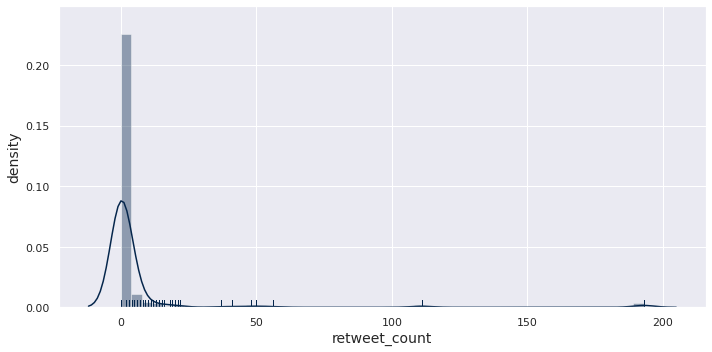

In [ ]:
plt.figure(figsize=(10, 5))
sns.distplot(df['retweet_count'], color='#05264c', rug=True, kde=True)
plt.xlabel('retweet_count',fontsize=14)
plt.ylabel('density',fontsize=14)
plt.tight_layout()

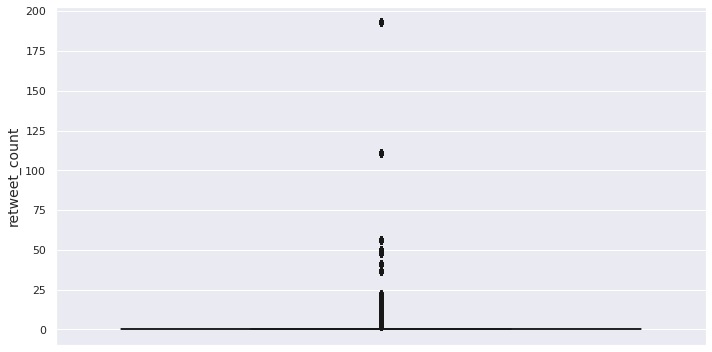

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(y=df['retweet_count'],color='#05264c')
plt.ylabel('retweet_count',fontsize=14)
plt.tight_layout()

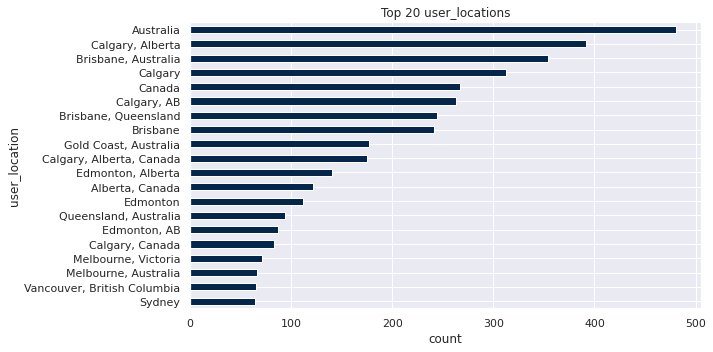

In [ ]:
def bar_chart(col,num):
    df[col].value_counts()[:num].plot.barh(color='#05264c', figsize=(10, 5))
    plt.title(f'Top {num} {col}s')
    plt.gca().invert_yaxis()
    plt.xlabel('count')
    plt.ylabel(col)
    plt.tight_layout()

bar_chart('user_location',20)

#  Classification 


First look at the distribution of tweets in the relevant/irrelevant


In [ ]:
y = df_clas['relevant']
plt.figure(figsize=(10,4))

print('Number of tweets:', len(df_clas))
print('Relevant:', sum(y), 'that is:' , round(sum(y)/len(y)*100,2), '%')
print('Non-relevant:', len(y)-sum(y), 'that is:' ,round((len(y)-sum(y))/len(y)*100,2),'%')

p1 = plt.barh(1,100,color='lightgreen')
p2 = plt.barh(1,(len(y)-sum(y))/len(y)*100,color='firebrick')

plt.legend((p1[0], p2[0]), ('Relevant', 'Non-relevant'),loc='upper center')
plt.yticks([1,1.8])
plt.title('Class balance',fontsize=16)
#plt.axis('off')


plt.show()

## Classic algorithms 

Here, we use the variable 'tokens'



In [ ]:
# define tfidf
tfidf = TfidfVectorizer(preprocessor=' '.join)

# test-train split
size = [0.2,0.8]

def text_fit(X, y, model,clf_model,size):   
    X_c = model.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0,test_size=size[0], train_size=size[1])
    clf = clf_model.fit(X_train, y_train)
    pred = clf.predict(X_test)
    performance(y_test.tolist(), pred)
   
    return clf,X_c,model


def print_words(model,clf_model,out):
        w = model.get_feature_names()
        if clf_model==clf_log:
          coef = clf_model.coef_.tolist()[0]
          STR = 'Coefficient'
          coeff_df = pd.DataFrame({'Word' : w, STR : coef})
          coeff_df = coeff_df.sort_values([STR, 'Word'], ascending=[0, 1])

          print('')
          print('-Top 5 relevant-')
          print(coeff_df.head(5).to_string(index=False))
          print('')
          print('-Top 5 non-relevant-')        
          print(coeff_df.tail(5).to_string(index=False))

        else:
          coef = clf_model.feature_importances_
          STR = 'Score'
          coeff_df = pd.DataFrame({'Word' : w, STR : coef})
          coeff_df = coeff_df.sort_values([STR, 'Word'], ascending=[0, 1])
          print('')
          print('-Top 10 important-')
          print(coeff_df.head(10).to_string(index=False))
  
        return coeff_df
    


In [ ]:
# define for each set 

X1 = df_clas1['tokens']
y1 = df_clas1['relevant']

X2 = df_clas2['tokens']
y2 = df_clas2['relevant']

X3 = df_clas3['tokens']
y3 = df_clas3['relevant']

### Logistic Regression

In [ ]:
print('1. Original tweets')
clf_log1,Xc_log1,tfidf_log1 = text_fit(X1, y1, tfidf, LogisticRegression(),size)
_ = print_words(tfidf_log1,clf_log1,True)

print('\n2. Remove keywords')
clf_log2,Xc_log2,tfidf_log2 = text_fit(X2, y2, tfidf, LogisticRegression(),size)
words2 = print_words(tfidf_log2,clf_log2,True)
words2.to_csv('words_LR.csv')


filename = 'LR.sav'
pickle.dump(clf_log2, open(filename, 'wb'))
filename = 'LR_tfidf.sav'
pickle.dump(tfidf_log2.vocabulary_, open(filename, 'wb'))


print('\n3. Replace with place')
clf_log3,X_c_log3,tfidf_log3 = text_fit(X3, y3, tfidf, LogisticRegression(),size)
_ = print_words(tfidf_log3,clf_log3,True)

1. Original tweets

Confusion matrix
[[996  50]
 [ 85 983]]
Accuracy: 0.9361400189214759
Precision:  0.9515972894482091
Recall:  0.9204119850187266
F1 Score:  0.9357448833888624

-Top 5 relevant-
       Word  Coefficient
      flood    16.613820
   yycflood    14.434089
    abflood    11.863177
 queensland     7.599411
   flooding     6.687898

-Top 5 non-relevant-
   Word  Coefficient
   dont    -1.381593
 hiring    -1.618828
   haha    -1.703779
   love    -1.816487
     im    -3.436558

2. Remove keywords

Confusion matrix
[[1001   45]
 [  84  984]]
Accuracy: 0.9389782403027436
Precision:  0.956268221574344
Recall:  0.9213483146067416
F1 Score:  0.9384835479256082

-Top 5 relevant-
     Word  Coefficient
    flood    26.836102
 flooding     8.352042
    water     4.269536
   floods     4.189364
  flooded     3.141550

-Top 5 non-relevant-
   Word  Coefficient
   dont    -1.483337
 hiring    -1.534544
   haha    -1.685822
   love    -1.853816
     im    -2.983908

3. Replace with pla

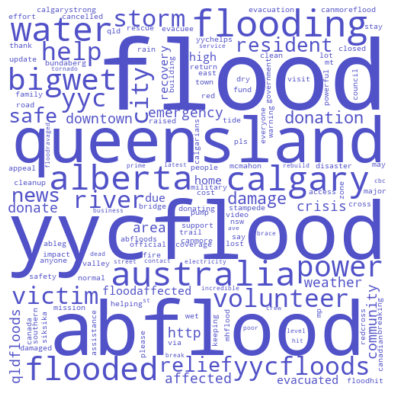

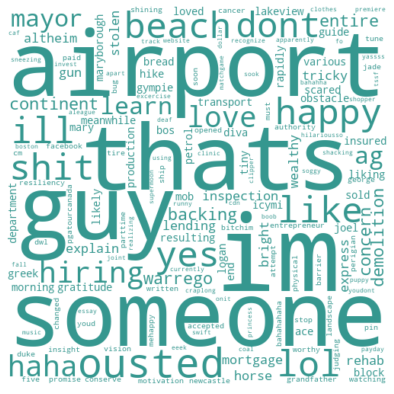

In [347]:
#words_df = pd.read_csv('words_LR.csv') # remove keywords
#words_df = words_df.drop([2]).reset_index(drop=True)
words_df = pd.read_csv('words_LR1.csv') # original Tweets 

pos_df = words_df[words_df['Coefficient'] >= 0]
neg_df = words_df[words_df['Coefficient'] < 0]
neg_df['Coefficient'] = -neg_df['Coefficient']

freq_pos = dict(zip(pos_df['Word'],[int(i)+10 for i in pos_df['Coefficient']]))
freq_neg = dict(zip(neg_df['Word'],[int(i)+10 for i in neg_df['Coefficient']]))

# define colors for the wordclouds
def color_func1(word=None, font_size=None, 
                   position=None, orientation=None, 
                   font_path=None, random_state=None):
    h = 240 # 0 - 360
    s = 52 # 0 - 100
    l =55 # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

def color_func2(word=None, font_size=None, 
                   position=None, orientation=None, 
                   font_path=None, random_state=None):
    h = 175 # 0 - 360
    s = 48 # 0 - 100
    l = 40 # 0 - 100
    return "hsl({}, {}%, {}%)".format(h, s, l)

plt.figure(figsize=(7,7))
#plt.subplot(1, 2, 1)
wordcloud = WordCloud(background_color='white',height=500,width=500,color_func=color_func1,min_font_size=8,collocations = False)
wordcloud.generate_from_frequencies(freq_pos)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('/Users/lisestyve/Desktop/rel1.png',bbox_inches = 'tight', pad_inches = 0)

plt.figure(figsize=(7,7))
#plt.subplot(1, 2, 2)
wordcloud = WordCloud(background_color='white',height=500,width=500,color_func=color_func2,min_font_size=8,collocations = False)
wordcloud.generate_from_frequencies(freq_neg)
img = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('/Users/lisestyve/Desktop/rel2.png',bbox_inches = 'tight', pad_inches = 0)

plt.show()

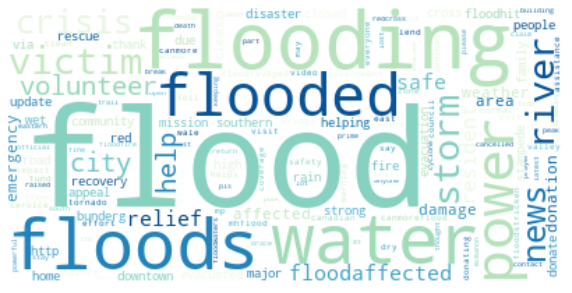

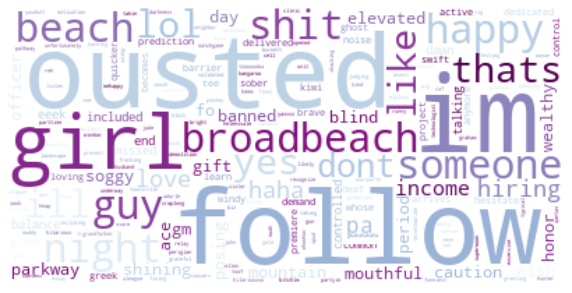

In [ ]:
words_df = pd.read_csv('../data/words_LR.csv')
words_df.head()

def wordclouds(words_df, save):
    #words_df = print_words(tfidf_log,clf_log,False)
    pos_df = words_df[words_df['Coefficient'] >= 0]
    neg_df = words_df[words_df['Coefficient'] < 0]
    neg_df['Coefficient'] = -neg_df['Coefficient']

    freq_pos = dict(
        zip(pos_df['Word'], [int(i)+10 for i in pos_df['Coefficient']]))
    freq_neg = dict(
        zip(neg_df['Word'], [int(i)+10 for i in neg_df['Coefficient']]))
    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(
        background_color='white',
        colormap='GnBu',
        collocations=False).generate_from_frequencies(freq_pos)

    img = plt.imshow(wordcloud, interpolation='bilinear')

    plt.axis("off")
    if save == 1:
        plt.savefig('positive.png')

    plt.show()

    plt.figure(figsize=(10, 10))
    wordcloud = WordCloud(
        background_color='white',
        colormap='BuPu',
        collocations=False
    ).generate_from_frequencies(freq_neg)

    img = plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    if save == 1:
        plt.savefig('negative.png')
    plt.show()
    
wordclouds(words2,0)

### Random Forrest

In [ ]:
print('1. Original tweets')
clf_RF,X_c_RF,tfidf_RF = text_fit(X1, y1, tfidf, RandomForestClassifier(max_depth=9, random_state=0),size)
_ = print_words(tfidf,clf_RF,True)

print('\n2. Remove keywords')
clf_RF,X_c_RF,tfidf_RF = text_fit(X2, y2, tfidf, RandomForestClassifier(max_depth=9, random_state=0),size)
_ = print_words(tfidf,clf_RF,True)
filename = 'RF.sav'
pickle.dump(clf_RF, open(filename, 'wb'))
filename = 'RF_tfidf.sav'
pickle.dump(tfidf_RF.vocabulary_, open(filename, 'wb'))


print('\n3. Replace with place')
clf_RF,X_c_RF,tfidf_RF = text_fit(X3, y3, tfidf, RandomForestClassifier(max_depth=9, random_state=0),size)
_ = print_words(tfidf,clf_RF,True)

1. Original tweets

Confusion matrix
[[997  49]
 [196 872]]
Accuracy: 0.8841059602649006
Precision:  0.9467969598262758
Recall:  0.8164794007490637
F1 Score:  0.8768225238813474

-Top 10 important-
       Word     Score
      flood  0.102466
  australia  0.043850
    calgary  0.042754
 queensland  0.040406
   yycflood  0.038987
    abflood  0.037290
         im  0.032989
      water  0.024297
     relief  0.022063
     crisis  0.019059

2. Remove keywords

Confusion matrix
[[1001   45]
 [  94  974]]
Accuracy: 0.934247871333964
Precision:  0.9558390578999019
Recall:  0.9119850187265918
F1 Score:  0.9333972208912313

-Top 10 important-
     Word     Score
    flood  0.108648
     help  0.024853
       im  0.023904
   crisis  0.022276
   relief  0.022224
    water  0.021390
 flooding  0.018409
 affected  0.018286
   victim  0.015802
     news  0.015037

3. Replace with place

Confusion matrix
[[987  59]
 [156 912]]
Accuracy: 0.8982970671712394
Precision:  0.9392378990731205
Recall:  0.853

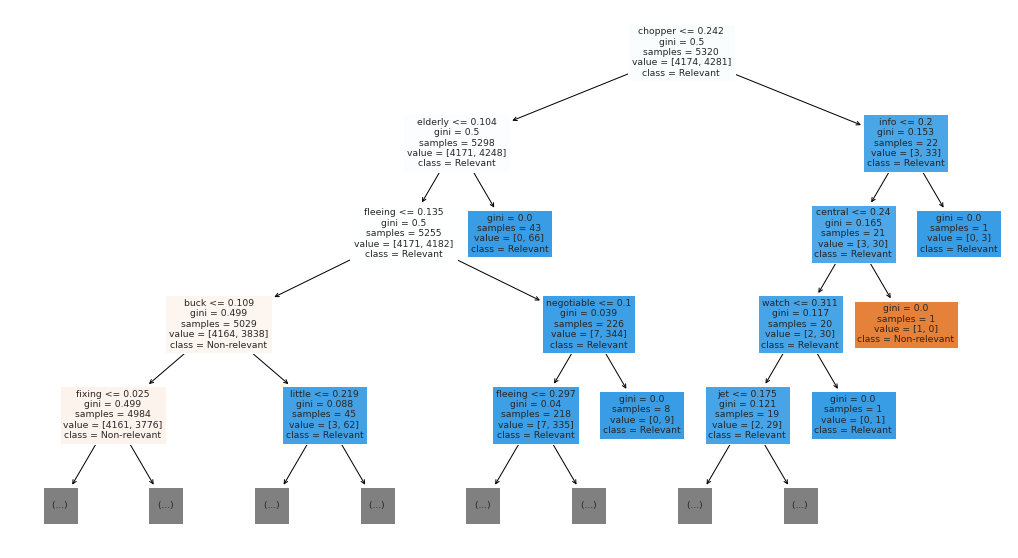

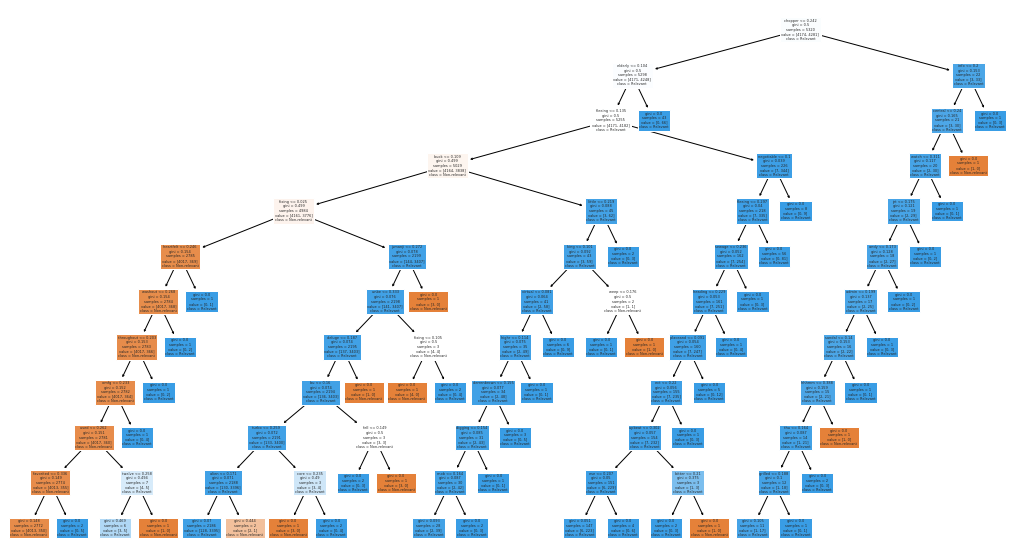

In [ ]:
from sklearn import tree
from sklearn.tree import export_text

names = ['Non-relevant','Relevant']
est = clf_RF2.estimators_[36]

M=[4,11]

for m in M:   
    plt.figure(figsize=(18,10))
    graph = tree.plot_tree(est, 
                       feature_names=w2,  
                       class_names=names,
                       filled=True,max_depth=m)
    
    for o in graph:
        arrow = o.arrow_patch
        if arrow is not None:
            arrow.set_edgecolor('black')
            arrow.set_linewidth(1)


## Deep learning 

**<font color='red'>Only run in CoLab</font>**

We use the variable 'text_DL'


#### Activation functions

In [337]:
#x = np.arange(-3.0, 3.0, 0.01)
x = range(-5, 5)

def sigmoid(x):
    return [1 / float(1 + np.exp(-i)) for i in x]

def softmax(x):
    return np.exp(x) / np.exp(x).sum()

relu = np.vectorize(lambda x: x if x > 0 else 0, otypes=[np.float])

def plot(func, col, lab):
    plt.ylim([-0.2, 1.2])
    plt.locator_params(nbins=5)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("z", fontsize=16)
    plt.ylabel("f(z)", fontsize=16)
    plt.axhline(lw=1, c='black')
    plt.axvline(lw=1, c='black')
    plt.grid(alpha=0.4, ls='-.')
    plt.box(on=None)
    plt.plot(x, func(x), c=col, lw=3, label=lab, alpha=0.8)
    plt.legend(fontsize=14, loc='best', frameon=False)

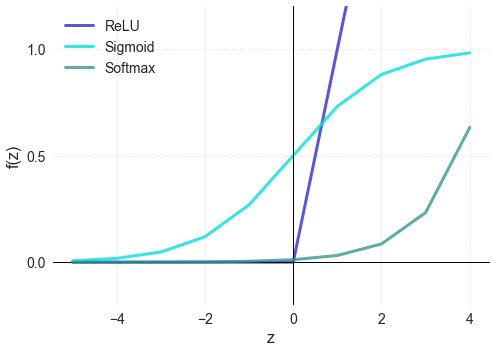

In [338]:
sns.set_style('whitegrid')
plt.figure(figsize=(7,5),tight_layout=True)
plot(relu, '#2c2cdb', 'ReLU')
plot(sigmoid, '#00e0e0', 'Sigmoid')
plot(softmax, '#35978f', 'Softmax')
plt.savefig('/Users/lisestyve/Desktop/sig_vs_relu.png')
plt.show()


### Pre-processing

In [ ]:
# load google news Word2Vec model 
word2vec_path = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def split(df_clas):
  # splitting data into test and train
  data_train, data_test = train_test_split(df_clas, test_size=0.20, random_state=42)

  print('Training vocabulary ')
  # build training vocabulary
  all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
  training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
  TRAINING_VOCAB = sorted(list(set(all_training_words)))
  print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
  print("Max sentence length is %s" % max(training_sentence_lengths))

  print('\nTesting vocabulary ')
  # build testing vocabulary 
  all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
  test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
  TEST_VOCAB = sorted(list(set(all_test_words)))
  print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
  print("Max sentence length is %s" % max(test_sentence_lengths))

  return data_train,data_test

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [ ]:

def final_embeddings(word2vec,data_train,data_test, MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE):

  # get embeddings
  training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

  # Tokenize and transform to integer index
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(data_train['text_DL'])

  X_train = tokenizer.texts_to_sequences(data_train['text_DL'])
  X_test = tokenizer.texts_to_sequences(data_test['text_DL'])

  vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
  train_word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(train_word_index))

  # Add pading to ensure all vectors have same dimensionality
  X_train = pad_sequences(X_train, padding='post', maxlen=MAX_SEQUENCE_LENGTH)
  y_train = data_train['relevant']

  X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

  #train embeddings 
  train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
  y_test = data_test['relevant']

  for word,index in train_word_index.items():
      train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

  print(train_embedding_weights.shape)

  return X_train, y_train, X_test, y_test, train_embedding_weights, vocab_size, tokenizer

In [ ]:
def predictions(data_test,model,tokenizer):

    #tokenizer.fit_on_texts(df['full_text'].tolist())
    sequences = tokenizer.texts_to_sequences(data_test['text_DL'])

    MAX_SEQUENCE_LENGTH  = 30
    new_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predictions =model.predict_classes(new_data, batch_size=1024, verbose=1)

    prediction_labels =  [i[0] for i in predictions.tolist()]
            
    return  prediction_labels

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc','o')
    plt.plot(x, val_acc, 'midnightblue', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss','o')
    plt.plot(x, val_loss, 'midnightblue', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
#parameters
MAX_SEQUENCE_LENGTH = 30 # longest text in train set
EMBEDDING_DIM = 300
RANDOM_STATE = 42
EPOCHS = 5
BS = 64

### CNN

In [ ]:
# Define CNN architecture
from tensorflow.keras import datasets, layers, models,regularizers
from keras.regularizers import l2
import tensorflow as tf


def train_CNN(df_clas,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE,EPOCS,BS):

  data_train, data_test = split(df_clas)
  print('\n')
  X_train, y_train, X_test, y_test, train_embedding_weights,vocab_size,tokenizer = final_embeddings(word2vec,data_train,data_test,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE)

  model = models.Sequential()
  model.add(layers.Embedding(vocab_size, EMBEDDING_DIM,weights=[train_embedding_weights], input_length=MAX_SEQUENCE_LENGTH,trainable=False))
  model.add(layers.Conv1D(128, kernel, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
  model.add(layers.GlobalMaxPooling1D())
  model.add(layers.Dense(32, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
 # model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dropout(0.1))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
  print('\n')
  print(model.summary())

  # Fit model

  num_epochs = EPOCHS
  batch_size = BS

  hist = model.fit(X_train, 
                  y_train, 
                  epochs=num_epochs, 
                  validation_split=0.2, 
                  shuffle=True, 
                  batch_size=batch_size)



  print('\n')
  loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
  print("Testing Accuracy:  {:.4f}".format(accuracy))

  predictions =model.predict_classes(X_test, batch_size=1024, verbose=1)
  prediction_labels =  [i[0] for i in predictions.tolist()]

  performance(y_test,prediction_labels)

  return model, hist, tokenizer


1. Original tweets

Training vocabulary 
73842 words total, with a vocabulary size of 11699
Max sentence length is 26

Testing vocabulary 
18477 words total, with a vocabulary size of 5109
Max sentence length is 20


Found 11699 unique tokens.
(11700, 300)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           3510000   
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 128)           192128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0     

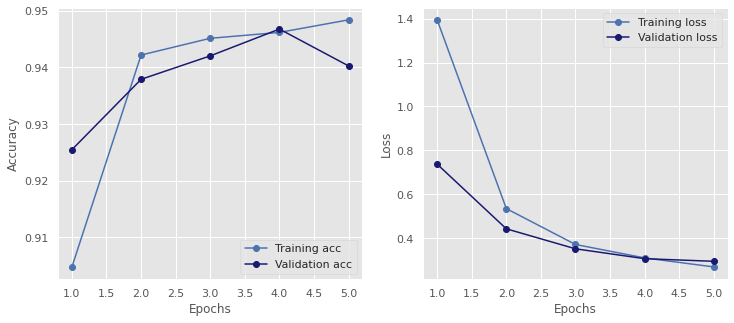

In [ ]:
print('1. Original tweets\n')
CNN1, hist1,tokenizer1 = train_CNN(df_clas1,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE,EPOCHS,BS)
plt.style.use('ggplot')

%matplotlib inline
plot_history(hist1)


2. Remove keywords

Training vocabulary 
69642 words total, with a vocabulary size of 11536
Max sentence length is 26

Testing vocabulary 
17425 words total, with a vocabulary size of 5042
Max sentence length is 20


Found 11536 unique tokens.
(11537, 300)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           3461100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 128)           192128    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0   

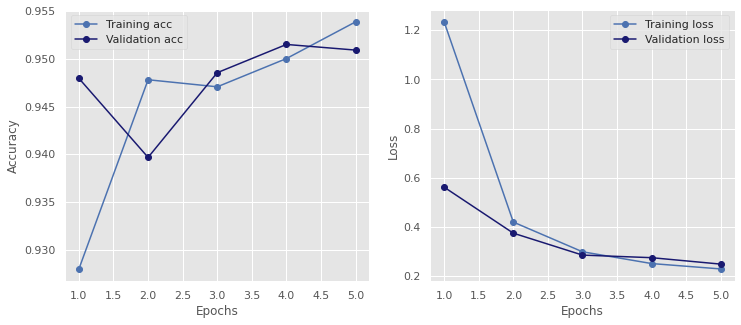

In [ ]:
print('2. Remove keywords\n')
CNN2,hist2,tokenizer2 = train_CNN(df_clas2,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE,EPOCHS,BS)
plt.style.use('ggplot')

%matplotlib inline
plot_history(hist2)
plt.savefig('CNN2')

3. Replace with place

Training vocabulary 
73842 words total, with a vocabulary size of 11654
Max sentence length is 26

Testing vocabulary 
18477 words total, with a vocabulary size of 5087
Max sentence length is 20


Found 11654 unique tokens.
(11655, 300)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           3496500   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 128)           192128    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

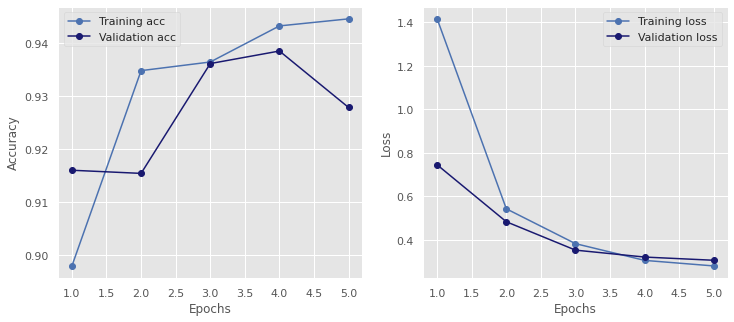

In [ ]:
print('3. Replace with place\n')

CNN3, hist3,tokenizer3 = train_CNN(df_clas3,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE,EPOCHS,BS)
plt.style.use('ggplot')

%matplotlib inline
plot_history(hist3)

Original Tweets


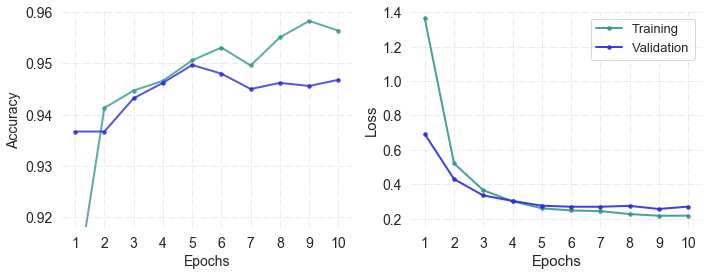

Remove keywords


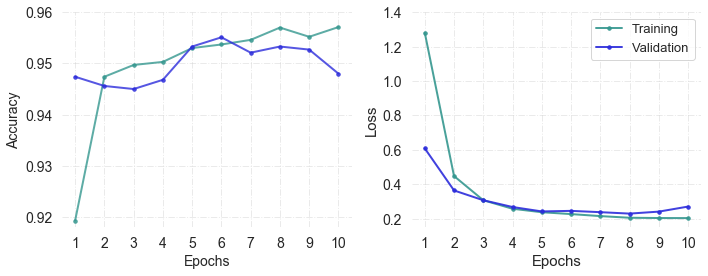

In [17]:
#values2 = [train_loss,train_acc,val_loss,val_acc]
sns.set()
blues = ['#2c2cdb', '#00e0e0', '#35978f']


def plot_history(train_loss, train_acc, val_loss, val_acc):

    x = range(1, len(train_loss) + 1)
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 4), tight_layout=True)

    plt.subplot(1, 2, 1)
    plt.plot(x, train_acc, blues[2], marker='.', alpha=0.8, markersize=7, lw=2)  
    plt.plot(x, val_acc, blues[0], marker='.', alpha=0.8, markersize=7, lw=2)
    plt.xticks(x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.ylim([0.918, 0.96])
    plt.yticks([0.92, 0.93, 0.94, 0.95, 0.96], fontsize=14)
    plt.grid(alpha=0.4, ls='-.')
    plt.box(on=None)
    #plt.legend(fontsize=14, loc='best', frameon=False)

    plt.subplot(1, 2, 2)
    plt.plot(x, train_loss, blues[2], label='Training', marker='.', alpha=0.9, markersize=7, lw=2)
    plt.plot(x, val_loss, blues[0], label='Validation', marker='.', alpha=0.9, markersize=7, lw=2)
    plt.xticks(x, fontsize=14)
    plt.ylim([0.15, 1.4])
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4], fontsize=14)
    plt.xlabel("Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.grid(alpha=0.4, ls='-.')
    plt.box(on=None)
    plt.legend(fontsize=13, loc='best', frameon=True)
    
    plt.savefig('/Users/lisestyve/Desktop/CNN2.png')
    plt.show()

print('Original Tweets')
plot_history(train_loss1, train_acc1, val_loss1, val_acc1)
print('Remove keywords')
plot_history(train_loss2,train_acc2,val_loss2,val_acc2)

In [ ]:
# save model
# MLP for Pima Indians Dataset Serialize to JSON and HDF5
from keras.models import model_from_json
from keras_preprocessing.text import tokenizer_from_json
import numpy
import os

# serialize model to JSON
model_json = CNN2.to_json()
with open("CNN.json", "w") as json_file:
    json_file.write(model_json)

tokenizer_json = tokenizer2.to_json()
with open('CNN_tokenizer.json','w') as f:
    f.write(tokenizer_json)

# serialize weights to HDF5
CNN2.save_weights("CNN.h5")
print("Saved model to disk")

Saved model to disk


#### Visualisation



In [ ]:
data_train, data_test = split(df_clas2)
print('\n')
X_train, y_train, X_test, y_test, train_embedding_weights,vocab_size,tokenizer = final_embeddings(word2vec,data_train,data_test,MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,RANDOM_STATE)


labels = []
tokens = []
for word,val in tokenizer.word_index.items():
       tokens.append(train_embedding_weights[val])
       labels.append(word)
       
       
d1 = pd.DataFrame()
d1['labels'] = labels
d1['embedding'] = tokens

d1.to_json('word_embeddings.json',orient='split')

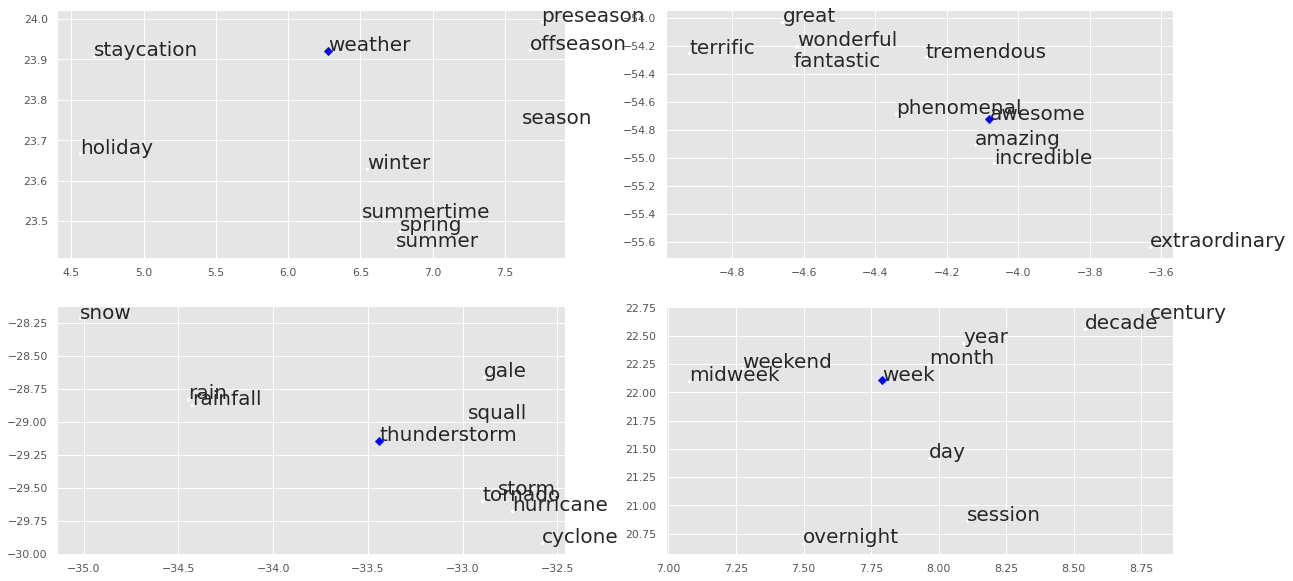

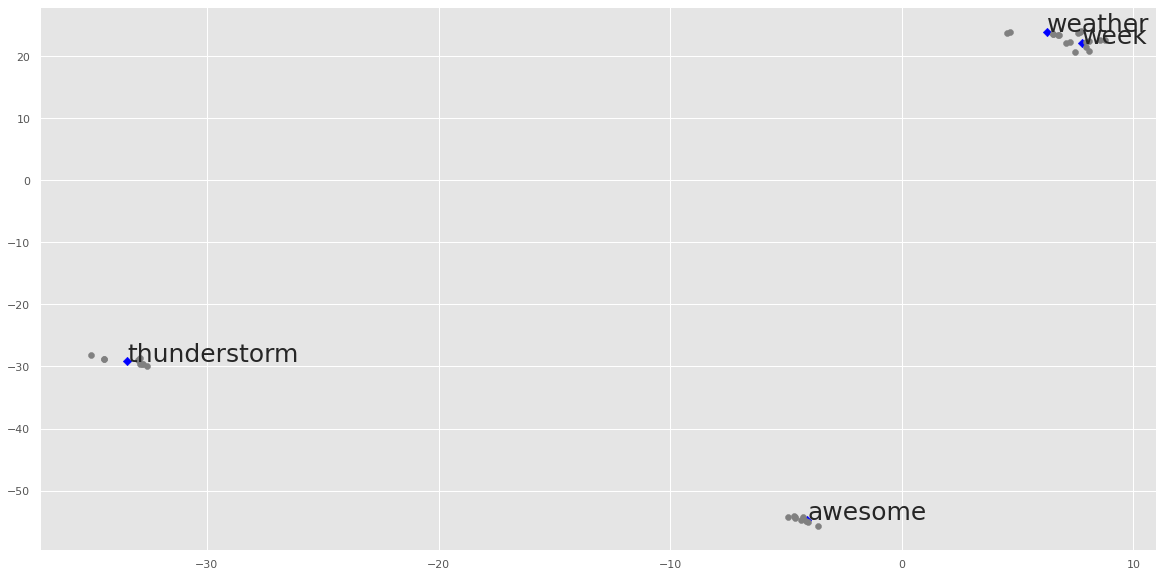

In [ ]:

fig = plt.figure(figsize=(20,10))

word_list = ['weather','awesome','thunderstorm', 'week']
words = word_df['labels']

for (word,num) in zip(word_list,range(1,6)):

  k = np.where(word_df['labels']==word)[0][0]


  some_pt = (x_coords[k],y_coords[k])
  ids = closest_node(some_pt, a, 10)


  X = []
  Y = []
  N = []

  for idx in ids:
    X.append(x_coords[idx])
    Y.append(y_coords[idx])
    N.append(words[idx])


  ax = fig.add_subplot(2,2,num)
  ax.scatter(X[1:],Y[1:], color='white', marker='.')
  ax.scatter(X[0],Y[0],color='blue', marker='D')
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  
  #ax.set_xlim(min(x_coords),max(x_coords))
  #ax.set_ylim(min(y_coords),max(y_coords))

  
  for i, txt in enumerate(N):
    ax.annotate(txt, (X[i], Y[i]), fontsize=20)


  fig2 = plt.figure(10, figsize=(20,10))
  plt.scatter(X[0],Y[0],color='blue', marker='D')
  plt.annotate(word, xy=(X[0],Y[0]), fontsize=25)
  plt.scatter(X[1:],Y[1:], color='grey', marker='o')

 # plt.gca().spines['right'].set_visible(False)
  #plt.gca().spines['top'].set_visible(False)
    
fig.savefig('words.png')
fig2.savefig('full_space.png')

##  Transfer learning 

**<font color='red'>Only run in CoLab</font>**

Using variable 'text_TL'

### ULMFiT 

https://towardsdatascience.com/transfer-learning-in-nlp-for-tweet-stance-classification-8ab014da8dde

https://github.com/floleuerer/fastai_ulmfit

In [ ]:
def get_data(df_clas):
  size = [0.2,0.8]

  X = df_clas['text_TL']
  y = df_clas['relevant']

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=size[0], train_size=size[1])

  df_train = pd.DataFrame()
  df_test = pd.DataFrame()

  df_train['relevant'] = y_train
  df_train['text'] = X_train 

  df_test['relevant'] = y_test
  df_test['text'] = X_test

  return df_train, df_test


In [ ]:
df_train1, df_test1 = get_data(df_clas1)
df_train2, df_test2 = get_data(df_clas2)
df_train3, df_test3 = get_data(df_clas3)

#### Language model fine-tuning 


In [ ]:
# Language model data

def langmodel_data(df_train,df_test):
  data_lm = TextLMDataBunch.from_df('', train_df=df_train, valid_df=df_test,min_freq=1,text_cols='text')
  data_lm.show_batch()

  # Save the language model data for re-use
  data_lm.save()
  
  return data_lm

In [ ]:
def langmodel_train(data_lm,enc_name):

  # Language model
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

    learn.lr_find(start_lr=1e-8, end_lr=1e2)
    learn.recorder.plot()

    #learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
    learn.fit_one_cycle(cyc_len=1, max_lr=1e-2,moms=(0.8, 0.7))

    learn.unfreeze()
    learn.fit_one_cycle(cyc_len=8, max_lr=1e-2,moms=(0.8, 0.7))

    # Save the fine-tuned encoder
    learn.save_encoder(enc_name)

    return learn

#### Classification

In [ ]:
# Classifier model data
def classifier_data(df_train,df_test,data_lm):
  data_clas = TextClasDataBunch.from_df('', train_df=df_train, valid_df=df_test, vocab=data_lm.train_ds.vocab, min_freq=1,bs=32)
  data_clas.save()

  return data_clas

In [ ]:
# Classifier

def classifier_train(data_clas,enc_name):
  classifier = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.5)
  classifier.load_encoder(enc_name)

  classifier.lr_find(start_lr=1e-8, end_lr=1e2)
  classifier.recorder.plot()

  classifier.fit_one_cycle(cyc_len=1, max_lr=1e-2, moms=(0.8, 0.7))
  classifier.recorder.plot_losses()
  classifier.freeze_to(-2)
  classifier.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))
  classifier.freeze_to(-3)
  classifier.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))
  classifier.unfreeze()
  classifier.fit_one_cycle(3, slice(1e-5,1e-2), moms=(0.8,0.7))

  return classifier
  

#### Build models

*Original tweets*

idx,text
0,have hit the east coast of xxmaj australia before recent bush fires hav ... xxbos xxmaj yea what she said malo aupito sis . xxmaj we r all goods .. x :) xxbos xxup iserv observes flooding in xxmaj calgary # image # xxup nasa xxbos xxmaj please : xxmaj you can donate to to help those affected by flooding in xxmaj alberta . # yycflood # abfloods xxbos xxmaj
1,"# abflood # yychero xxbos xxmaj how long ago was a town erected in "" xxmaj high xxmaj river "" and why did n't they think that the river could get that "" high "" again ? # abflood xxbos could have used a penske today . xxmaj too bad you left early . xxbos xxmaj pres / xxup ceo says they need to get into the # xxmaj saddledome"
2,"a couple of years ago i smashed my phone and broke the tv when xxmaj andy xxmaj carroll was sold ! xxbos haha especially the way he manoeuvres round petrol stations ! ! xxbos xxmaj sending love to all those affected by the flooding in xxmaj calgary , xxmaj canmore , xxmaj high xxmaj river , xxmaj okotoks , xxmaj lethbridge and every ... xxbos hahaha , wicked profile pic"
3,focused on xxmaj bundaberg flood : xxup queensland xxmaj premier xxmaj campbell xxmaj newman plans to survey the flood damage in xxmaj bundaberg on xxmaj tuesday . xxbos xxmaj wishing the best to all those affected in xxmaj alberta # abflood xxbos xxmaj queensland 's flood crisis deepens - xxmaj the xxmaj australian # news xxbos xxmaj must you you basic bitch ? xxmaj urgh i am done with today
4,"xxmaj french really gets me going ! xxmaj ooh la la ! xxbos everyone in areas of flood and heavy rains in xxmaj australia . my thoughts are with you . stay safe and be vigil . please take care . xxbos does n't quite have the tact , good manner and empathy of \n xxmaj in very similar circumstances . \n # bigwet # qldfloods xxbos xxmaj"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,5.449234,4.566654,0.230195,00:07


epoch,train_loss,valid_loss,accuracy,time
0,4.436342,4.183314,0.288028,00:10
1,4.213590,4.134674,0.296246,00:10
2,3.860020,4.169125,0.301563,00:10
3,3.392789,4.296084,0.304018,00:10
4,2.868098,4.466299,0.304261,00:11
5,2.268939,4.694685,0.305824,00:11
6,1.751411,4.833876,0.304830,00:11
7,1.409464,4.890024,0.305114,00:11


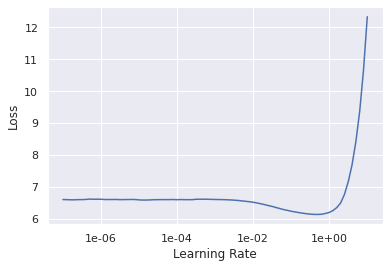

In [ ]:
# language learner 
data_lm1 = langmodel_data(df_train1,df_test1)
learn1 = langmodel_train(data_lm1,'ft_enc1')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.312244,0.269907,0.898770,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.266158,0.217335,0.917692,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.203626,0.200630,0.930937,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.190663,0.191855,0.938032,00:14
1,0.156434,0.195721,0.947493,00:14
2,0.080736,0.190490,0.948439,00:14


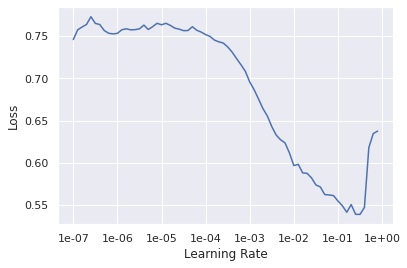

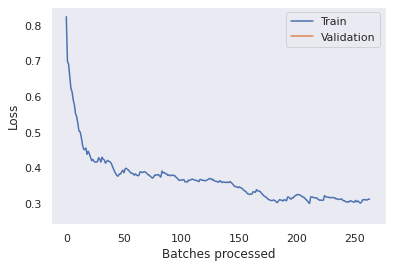

In [ ]:
# classification
data_clas1 = classifier_data(df_train1,df_test1,data_lm1)
classifier1 = classifier_train(data_clas1,'ft_enc1')
classifier1.export('ULMFiT1.pkl')


*Remove keywords*

idx,text
0,recent bush fires hav ... xxbos xxmaj yea what she said malo aupito sis . xxmaj we r all goods .. x :) xxbos xxup iserv observes flooding in # image # xxup nasa xxbos xxmaj please : xxmaj you can donate to to help those affected by flooding in . # flood # floods xxbos xxmaj ok so i spent the weekend buying soa t shirts . xxmaj also
1,"xxmaj high xxmaj river "" and why did n't they think that the river could get that "" high "" again ? # flood xxbos could have used a penske today . xxmaj too bad you left early . xxbos xxmaj pres / xxup ceo says they need to get into the # xxmaj saddledome ( once it 's deemed safe ) and assess the damage and start the clean"
2,"broke the tv when xxmaj andy xxmaj carroll was sold ! xxbos haha especially the way he manoeuvres round petrol stations ! ! xxbos xxmaj sending love to all those affected by the flooding in , xxmaj canmore , xxmaj high xxmaj river , xxmaj okotoks , xxmaj lethbridge and every ... xxbos hahaha , wicked profile pic . xxmaj love it . xxbos xxmaj financial relief for flood victims"
3,"the n # news xxbos xxmaj must you you basic bitch ? xxmaj urgh i am done with today just go home . xxbos 8x10 xxmaj handmade xxmaj diamond xxmaj willow xxmaj picture xxmaj frame in xxmaj cochrane , ( from xxbos breakingnews : xxmaj hundreds stranded as flood crisis hits s \n xxup bbc xxmaj news : xxmaj rescuers are trying to xxbos xxmaj andy xxmaj murray and"
4,"quite have the tact , good manner and empathy of \n xxmaj in very similar circumstances . \n # # floods xxbos xxmaj rutland xxmaj park is also coordinating volunteers to help out . xxmaj visit : for more details . # flood # xxup w11 xxbos xxmaj sorting out the essentials at xxmaj siksika . xxmaj more volunteers needed but no more clothes # flood xxbos good"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,5.609957,4.711372,0.215670,00:08


epoch,train_loss,valid_loss,accuracy,time
0,4.626929,4.326710,0.268616,00:10
1,4.361784,4.267391,0.279308,00:10
2,3.993091,4.301194,0.284531,00:10
3,3.526328,4.516556,0.278281,00:10
4,2.978931,4.634279,0.288594,00:10
5,2.389286,4.865891,0.286585,00:10
6,1.847308,5.024162,0.286451,00:10
7,1.482484,5.078346,0.285982,00:10


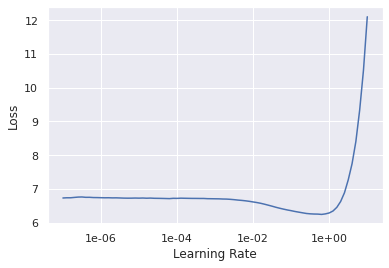

In [ ]:
# language learner 
data_lm2 = langmodel_data(df_train2,df_test2)
learn2 = langmodel_train(data_lm2,'ft_enc2')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.282494,0.265773,0.906812,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.243897,0.239950,0.905393,00:07


epoch,train_loss,valid_loss,accuracy,time
0,0.205176,0.188592,0.936613,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.194796,0.197232,0.939924,00:14
1,0.148503,0.179844,0.948439,00:13
2,0.104790,0.196936,0.949385,00:13


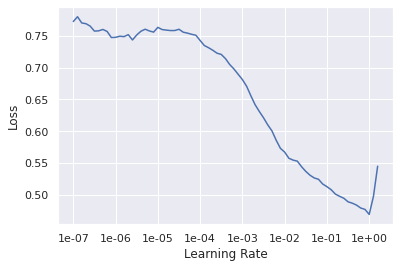

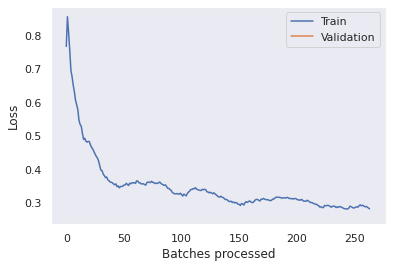

In [ ]:
# classification
data_clas2 = classifier_data(df_train2,df_test2,data_lm2)
classifier2 = classifier_train(data_clas2,'ft_enc2')
classifier2.export('ULMFiT2.pkl')

*Replace places*

idx,text
0,east coast of place before recent bush fires hav ... xxbos xxmaj yea what she said malo aupito sis . xxmaj we r all goods .. x :) xxbos xxup iserv observes flooding in place # image # xxup nasa xxbos xxmaj please : xxmaj you can donate to to help those affected by flooding in place . # placeflood # places xxbos xxmaj ok so i spent the weekend
1,"placehero xxbos xxmaj how long ago was a town erected in "" xxmaj high xxmaj river "" and why did n't they think that the river could get that "" high "" again ? # place xxbos could have used a penske today . xxmaj too bad you left early . xxbos xxmaj pres / xxup ceo says they need to get into the # xxmaj saddledome ( once it"
2,"couple of years ago i smashed my phone and broke the tv when xxmaj andy xxmaj carroll was sold ! xxbos haha especially the way he manoeuvres round petrol stations ! ! xxbos xxmaj sending love to all those affected by the flooding in place , xxmaj canmore , xxmaj high xxmaj river , xxmaj okotoks , xxmaj lethbridge and every ... xxbos hahaha , wicked profile pic . xxmaj"
3,"in place on xxmaj tuesday . xxbos xxmaj wishing the best to all those affected in place # place xxbos place 's flood crisis deepens - xxmaj the placen # news xxbos xxmaj must you you basic bitch ? xxmaj urgh i am done with today just go home . xxbos 8x10 xxmaj handmade xxmaj diamond xxmaj willow xxmaj picture xxmaj frame in xxmaj cochrane , place ( from xxbos"
4,"heavy rains in place . my thoughts are with you . stay safe and be vigil . please take care . xxbos does n't quite have the tact , good manner and empathy of \n xxmaj in very similar circumstances . \n # place # placefloods xxbos xxmaj rutland xxmaj park is also coordinating volunteers to help out . xxmaj visit : for more details . # placeflood"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,5.581353,4.652072,0.216985,00:08


epoch,train_loss,valid_loss,accuracy,time
0,4.519819,4.260798,0.270840,00:10
1,4.286783,4.190094,0.281879,00:10
2,3.926840,4.217471,0.289813,00:10
3,3.458323,4.371137,0.291315,00:10
4,2.907246,4.575185,0.293527,00:10
5,2.303386,4.806694,0.284842,00:11
6,1.782633,4.933234,0.293202,00:11
7,1.431623,4.986469,0.292614,00:11


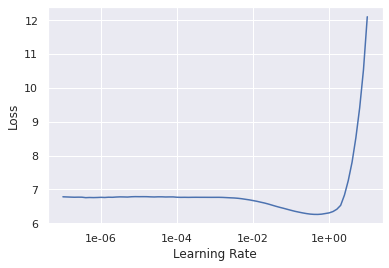

In [ ]:
# language learner 
data_lm3 = langmodel_data(df_train3,df_test3)
learn3 = langmodel_train(data_lm3,'ft_enc3')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time
0,0.318755,0.290034,0.892621,00:05


epoch,train_loss,valid_loss,accuracy,time
0,0.251520,0.239716,0.915799,00:06


epoch,train_loss,valid_loss,accuracy,time
0,0.209781,0.221663,0.923368,00:10


epoch,train_loss,valid_loss,accuracy,time
0,0.183303,0.223386,0.928098,00:14
1,0.143154,0.203274,0.931883,00:14
2,0.111426,0.208105,0.934248,00:14


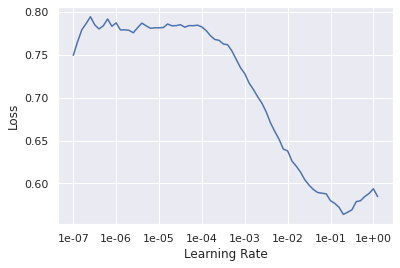

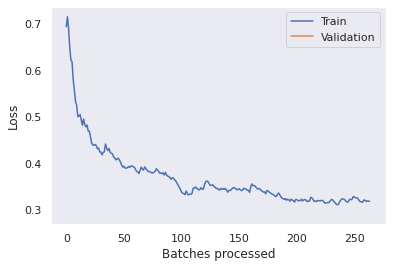

In [ ]:
# classification
data_clas3 = classifier_data(df_train3,df_test3,data_lm3)
classifier3 = classifier_train(data_clas3,'ft_enc3')
classifier3.export('ULMFiT3.pkl')

#### Performance

In [ ]:
# get predictions
#cl = load_learner('','ULMFiT1.pkl')
classifier1.data.add_test(df_test1['text'])
preds, _ = classifier1.get_preds(ds_type=DatasetType.Test)
targets =df_test1['relevant']
predictions = np.argmax(preds, axis=1)

_ = performance(targets,predictions)


Confusion matrix
[[ 991   55]
 [  51 1017]]
Accuracy: 0.9498580889309366
Precision:  0.9486940298507462
Recall:  0.952247191011236
F1 Score:  0.9504672897196261


In [ ]:
# get predictions
#cl = load_learner('','ULMFiT1.pkl')
classifier2.data.add_test(df_test2['text'])
preds, _ = classifier2.get_preds(ds_type=DatasetType.Test)
targets =df_test2['relevant']
predictions = np.argmax(preds, axis=1)

_ = performance(targets,predictions)


Confusion matrix
[[ 994   52]
 [  54 1014]]
Accuracy: 0.9498580889309366
Precision:  0.9512195121951219
Recall:  0.949438202247191
F1 Score:  0.9503280224929709


In [ ]:
# get predictions
#cl = load_learner('','ULMFiT1.pkl')
classifier3.data.add_test(df_test3['text'])
preds, _ = classifier3.get_preds(ds_type=DatasetType.Test)
targets =df_test3['relevant']
predictions = np.argmax(preds, axis=1)

_ = performance(targets,predictions)


Confusion matrix
[[990  56]
 [ 84 984]]
Accuracy: 0.9337748344370861
Precision:  0.9461538461538461
Recall:  0.9213483146067416
F1 Score:  0.9335863377609108


## Performance comparison

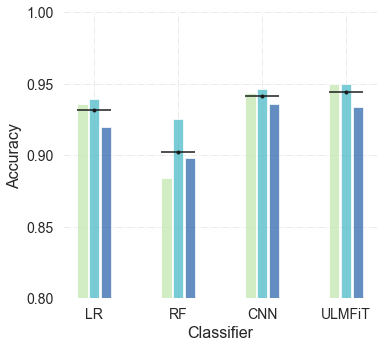

In [109]:
org = [0.93610, 0.88410, 0.94320, 0.94990]
rem = [0.93900, 0.92530, 0.94610, 0.94990]
rep = [0.92010, 0.89820, 0.93570, 0.93380]

avg = [(i+j+k)/3 for (i, j, k) in zip(org, rem, rep)]

x = np.arange(4)
width = 0.125
xlabs = ['LR', 'RF', 'CNN', 'ULMFiT']

sns.set_style('whitegrid')
plt.figure(figsize=(5.5, 5), tight_layout=True)
plt.bar(x-0.14, org, width, label='Original Tweets', color=blues[0], alpha=0.8)
plt.bar(x, rem, width, label='Remove keywords', color=blues[1], alpha=0.7)
plt.bar(x+0.14, rep, width, label='Replace places', color=blues[2], alpha=0.7)
plt.plot(x, avg, ".", color='k', mfc='k')
plt.hlines(y=avg[0], xmin=-0.2, xmax=0.2, color='k')
plt.hlines(y=avg[1], xmin=1-0.2, xmax=1+0.2, color='k')
plt.hlines(y=avg[2], xmin=2-0.2, xmax=2+0.2, color='k')
plt.hlines(y=avg[3], xmin=3-0.2, xmax=3+0.2, color='k')
plt.xticks([0, 1, 2, 3], xlabs, fontsize=14)
plt.ylim([0.8, 1])
plt.yticks([0.8, 0.85, 0.9, 0.95, 1], fontsize=14)
plt.xlabel("Classifier", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.grid(alpha=0.4, ls='-.')
plt.box(on=None)
plt.show()

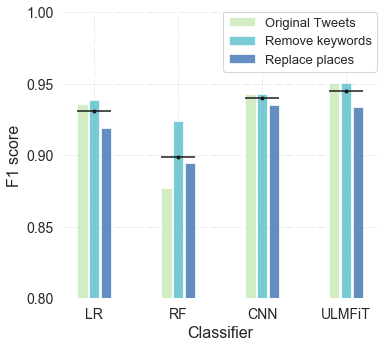

In [110]:
org = [0.9357, 0.8768, 0.9425, 0.9505]
rem = [0.9385, 0.9243, 0.9430, 0.9503]
rep = [0.9193, 0.8946, 0.9351, 0.9336]

avg = [(i+j+k)/3 for (i, j, k) in zip(org, rem, rep)]

x = np.arange(4)
width = 0.125
xlabs = ['LR', 'RF', 'CNN', 'ULMFiT']

sns.set_style('whitegrid')
plt.figure(figsize=(5.5, 5), tight_layout=True)
plt.bar(x-0.14, org, width, label='Original Tweets', color=blues[0], alpha=0.8)
plt.bar(x, rem, width, label='Remove keywords', color=blues[1], alpha=0.7)
plt.bar(x+0.14, rep, width, label='Replace places', color=blues[2], alpha=0.7)
plt.plot(x, avg, ".", color='k', mfc='k')
plt.hlines(y=avg[0], xmin=-0.2, xmax=0.2, color='k')
plt.hlines(y=avg[1], xmin=1-0.2, xmax=1+0.2, color='k')
plt.hlines(y=avg[2], xmin=2-0.2, xmax=2+0.2, color='k')
plt.hlines(y=avg[3], xmin=3-0.2, xmax=3+0.2, color='k')
plt.xticks([0, 1, 2, 3], xlabs, fontsize=14)
plt.ylim([0.8, 1])
plt.yticks([0.8, 0.85, 0.9, 0.95, 1], fontsize=14)
plt.xlabel("Classifier", fontsize=16)
plt.ylabel("F1 score", fontsize=16)
plt.grid(alpha=0.4, ls='-.')
plt.box(on=None)
plt.legend(fontsize=13, loc='best', frameon=True, bbox_to_anchor=(1.02, 1.025))
plt.show()

# Localisation 



In this section, we look into getting a location for the tweets. This is prioritesed in the four levels stated here.

*Note that the “coordinates” attributes is formatted as [LONGITUDE, latitude], while the “geo” attribute is formatted as [latitude, LONGITUDE].

1. Geotagged coordinates
2. Geotagged place
3. Geoparsed from text
4. Registered user location


## Geo and place attributes

In [ ]:
def get_centers(df_rel):
    
    #users with places and not geo
    place_df = df_rel[(df_rel['geo'].isna()) & (df_rel['place'].notna())].reset_index(drop=True)

    # add place_id
    place_df['place_id'] =[place_df['place'][i]['id'] for i in range(len(place_df))]

    # get dataframe with places metadata
    places = [place_df['place'][i] for i in range(len(place_df))]
    df_places= pd.DataFrame(places)
    df_places= df_places.rename(columns={'id':'place_id'})
    df_places = df_places.drop_duplicates(subset=['place_id'])

    # merge to get all place details
    place_df2 =pd.merge(place_df.drop(columns=['place']),df_places, on='place_id',how='inner')

    cols=['tweet_id','place_type', 'name',
           'full_name', 'country',
           'bounding_box']
    # merge to all data

    df_rel = pd.merge(df_rel,place_df2[cols],on='tweet_id',how='left').reset_index(drop=True)
    df_rel['geo'] = df_rel['geo'].fillna(df_rel['bounding_box'])
    
    # get centers of polygons
    # create variable with type point or polygon
    # create 'center' variable with either point or center of polygon

    df_try =  df_rel[~df_rel['geo'].isna()].reset_index(drop=True)
    df_try['location_type'] = [g['type'] for g in df_try['geo']]
    df_try['coordinates2'] = [g['coordinates'] for g in df_try['geo']]

    # get centers of polygon or just point
    centers = []

    for i in range(len(df_try)):
        if df_try['location_type'][i]=='Polygon':      
            center = list(np.average(df_try['coordinates2'][i][0],axis=0))[::-1]
            centers.append(center)
        else:
            centers.append(df_try['coordinates2'][i])
    df_try['centers'] = centers

    # merge with df_rel
    df_rel = pd.merge(df_rel,df_try[['tweet_id','location_type','centers']],on='tweet_id',how='left').reset_index(drop=True)
    
    return df_rel

## Geo-parsing 

1) toponym recognition

Use spacy entitity recognition

In [ ]:
def geoparsing(df_rel):

    #import en_core_web_sm
    #nlp = en_core_web_sm.load()
    
    nlp = spacy.load('en_core_web_lg')

    df_rel['geoparsing'] = ''

    for i in range(len(df_rel)):      
        
        if (i % 2500) == 0:
            print(i)
            
        places = nlp(df_rel['tweet'][i]).ents
        locs=[]
        for ent in places:
            if ent.label_ == 'GPE':
                locs.append(ent.text.lower())
            if len(locs)!=0:
                df_rel['geoparsing'][i] = locs
            else:
                df_rel['geoparsing'][i] = ['NAN']

    # get count of matches
    df_rel['geoparsing_count'] = [len(m) for m in df_rel['geoparsing']]

    #replace empty
    df_rel['geoparsing'] = [np.unique(row) for row in df_rel['geoparsing']]

    return df_rel

2) Look up table for coordinates

- user location 
- geoparsed locations


In [ ]:
# get unique user locations appearing over 10 times in list

def user_locs(df_rel):

    df_rel['user_location_lower'] = ''

    for i,u in enumerate(df_rel['user_location'].str.lower()):
        try:
            df_rel['user_location_lower'][i] = u.split(',')[0] 
        except:
            None

    # get unique user locations mentioned more than threshold

    values, counts = np.unique(list(df_rel['user_location_lower']),return_counts=True)


    # define threshold
    a = np.sort(counts)
    a = [i for i in a if i>1]
    min = np.percentile(a, 5)
    max = np.percentile(a, 95)
    a = [i for i in a if i>min]
    a = [i for i in a if i<max]
    thres = np.percentile(a,50)
    print('Threshold user locations:  ', thres)

    vals = values[counts>=thres]
    user_list1 = vals[(vals!='') & (vals!='NAN')]

    user_list = list(np.unique([u.split(',')[0] for u in user_list1]))
    user_list =[x for x in user_list if x[0]!='#']
    
    return user_list

   

In [ ]:
def geo_locs(df_rel):
       
    # get list of geoparsed locations
    gps = list(df_rel['geoparsing'])
    flat_gps = list(itertools.chain(*gps))


    # get unique geoparsed location mentioned more than threshold
    values, counts = np.unique(flat_gps,return_counts=True)

    # define threshold
    a = np.sort(counts)
    a = [i for i in a if i>1]
    min = np.percentile(a, 5)
    max = np.percentile(a, 95)
    a = [i for i in a if i>min]
    a = [i for i in a if i<max]
    thres = np.percentile(a,50)
    print('Threshold geoparsing:  ', thres)

    vals = values[counts>=thres]
    gp_list = list(vals[(vals!='') & (vals!='NAN')])
    
    return gp_list




In [ ]:
def lookup_table(user_list,gp_list):
     
    # initialize geolocator
    geolocator = Nominatim(user_agent='my_app') 
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    # create look up table for unique locations - combining user and geoparsed
    df_lookup = pd.DataFrame()
    df_lookup['location'] = list(np.unique(user_list+gp_list))

    # get coordinates
    df_lookup['coordinates']= ''

    for i,loc in enumerate(df_lookup['location']):  

        if (i % 100) == 0:
            print(i)

        if str(loc)!='nan':
            try:
                df_lookup['coordinates'][i]=[geolocator.geocode(loc).latitude,geolocator.geocode(loc).longitude]
            except:
                df_lookup['coordinates'][i] = np.nan
        else:
            df_lookup['coordinates'][i] = np.nan

    df_lookup=df_lookup.dropna()
    
    return df_lookup


In [ ]:
def add_coords(df_rel,df_lookup):
    # add index to flatten out geoparsing - when more than one location
    df_rel['index'] = df_rel.index

    b_flat = pd.DataFrame([[i, x] 
                   for i, y in df_rel['geoparsing'].apply(list).iteritems() 
                       for x in y], columns=list('IB'))
    b_flat = b_flat.set_index('I')

    df_match = df_rel[['index']].merge(b_flat, left_index=True, right_index=True)
    df_match.rename(columns={'B':'location'},inplace=True)

    # look up geoparse locations and join to main data set df_rel
    df_merge1 = pd.merge(df_match,df_lookup,on='location').sort_values(by='index')
    hej = pd.DataFrame(df_merge1.groupby(['index'])['coordinates'].apply(list)).reset_index()
    hej.rename(columns={'coordinates':'gp_coords'},inplace=True)
    df_rel2 = pd.merge(df_rel,hej,on='index',how='left')
    
    # get user coordinates using look up table
    df_rel2['location'] = df_rel2['user_location_lower']
    df_rel3 = pd.merge(df_rel2,df_lookup.rename(columns={'coordinates':'user_coordinates'}),on='location',how='left')
    df_rel3.drop(columns=['location','index'],inplace=True)


    # drop if does not have any coordinates available
    df_rel4 = df_rel3.dropna(subset=['centers','gp_coords', 'user_coordinates'],how='all').reset_index(drop=True)
    
    return df_rel4



*2) toponym resolution*


Geoparse coords
    - if geoparse coords have two locations closer than 1500 km, randomnly choose one
    - if geoparse coords have more than two then take two with shortest distance, if below 1500 km, randomnly choose one
    - else just use coords



In [ ]:
def final_geocoords(df_rel4):
    
    # define dataframe with only geoparsing locations
    df_gp =df_rel4[df_rel4['gp_coords'].notna()].reset_index(drop=True)

    # get count of matches
    df_gp['gp_count'] = [len(m) for m in df_gp['gp_coords']]
  
    earth = 6371000/1000

    # define new variable to have the chosen coordinates
    df_gp['gp_coords1'] = ''
    df_gp['distance'] = ''

    for j in range(len(df_gp)):

        x = df_gp['gp_coords'].iloc[j]
        count = df_gp['gp_count'].iloc[j]

        # if more than 2 locations, get two closest
        if count>2:    
            xx = [[radians(i[0]),radians(i[1])] for i in x]
            mat = np.round(haversine_distances(xx, xx)*earth)
            idx = list(np.unravel_index(np.where(mat!=0, mat, mat.max()+1).argmin(), mat.shape))

            if mat[idx[0],idx[1]]<1500:
              rand = np.random.choice([0,1])
              new_coords = x[idx[rand]]
            else:
              new_coords = 'NAN'

            df_gp['gp_coords1'].iloc[j]=new_coords
            df_gp['distance'].iloc[j] = mat[idx[0],idx[1]]


            #new_coords = [np.average([x[idx[0]][0],x[idx[1]][0]]),np.average([x[idx[0]][1],x[idx[1]][1]])] 
            
        elif count==2:
     
            xx = [[radians(i[0]),radians(i[1])] for i in x]
            mat = np.round(haversine_distances(xx, xx)*earth)

            if mat[0,1]<1500:
              rand = np.random.choice([0,1])
              new_coords = x[rand]
            else:
              new_coords = 'NAN'

          #  new_coords = [np.average([x[0][0],x[1][0]]),np.average([x[0][1],x[1][1]])]
            df_gp['gp_coords1'].iloc[j]=new_coords
            df_gp['distance'].iloc[j] = mat[0,1]
            
    
        elif count==1:   
            df_gp['gp_coords1'].iloc[j] = x[0]
            df_gp['distance'].iloc[j] = 0
          
       
        
    # merge with final dataframe
    df_rel5 = pd.merge(df_rel4,df_gp[['tweet_id','gp_coords1','distance']],on='tweet_id',how='left').reset_index(drop=True)
            
    return df_rel5


Choose location in order:
1. 'centers' if location_type = Point
2. 'centers' if location_type = Polygon
3. geoparsed coords
5. user location coords

In [ ]:
def final_data(df_rel5):

    #replace np.nan with NAN - only way to make if statement
    df_rel5['gp_coords1'] = df_rel5['gp_coords1'].replace(np.nan,'NAN')
    df_rel5['user_coordinates'] = df_rel5['user_coordinates'].replace(np.nan,'NAN')


    # define columns for final coordinates - type
    # 1 'centers' if location_type = Point
    # 2  'centers' if location_type = Polygon
    # 3  geoparse coords
    # 4 user coords
    # NAN

    df_rel5['final_coords'] = ''
    df_rel5['localization'] = ''

    for i in range(len(df_rel5)):

            # 'centers' if location_type = Point
        if df_rel5['location_type'].iloc[i] == 'Point':
            df_rel5['final_coords'].iloc[i] = df_rel5['centers'].iloc[i]
            df_rel5['localization'].iloc[i]  = 'Geotagged coordinates'

            # 'centers' if location_type = Polygon

        elif df_rel5['location_type'].iloc[i] == 'Polygon':
            df_rel5['final_coords'].iloc[i] = df_rel5['centers'].iloc[i]
            df_rel5['localization'].iloc[i]  = 'Geotagged place'

            # geoparse coords 
        elif df_rel5['gp_coords1'].iloc[i] !='NAN':
            df_rel5['final_coords'].iloc[i] = df_rel5['gp_coords1'].iloc[i]
            df_rel5['localization'].iloc[i]  = 'Geoparsed from Tweet'

            # user coords
        elif df_rel5['user_coordinates'].iloc[i] !='NAN':
            df_rel5['final_coords'].iloc[i] = df_rel5['user_coordinates'].iloc[i]
            df_rel5['localization'].iloc[i]  = 'Registered user location'

             # nan
        else:
            df_rel5['final_coords'].iloc[i] = 'NAN'
            df_rel5['localization'].iloc[i]  = 'NAN'


    df_rel5 = df_rel5[df_rel5['final_coords']!='NAN'].reset_index(drop=True)
    
    return df_rel5



Some coords are duplicates. In order to map them, we add noise to them using kernel density estimation. 

Mean = coordinates; Sigma = [0.7,0][0,0.7], N = number of duplicates

In [ ]:

def addnoise_coords(final_df):

    # get as string
    final_df['final_coords_str'] = final_df['final_coords'].astype(str)

    # duplicates of full_text
    dupl = final_df[final_df.duplicated(subset='final_coords_str',keep=False)].sort_values("final_coords_str")
    print(f'Number of duplicate coordinates: {len(dupl)} corresponding to {np.round(len(dupl)/len(final_df)*100,1)} %')
    duplicates = dupl[['final_coords_str']].groupby(dupl[['final_coords_str']].columns.tolist()).size().reset_index().rename(columns={0:'duplicates'})
    
    
     # merge duplicates counts on df
    final_df = pd.merge(final_df,duplicates,on='final_coords_str',how='outer').reset_index(drop=True)
   
    final_df['duplicates'].fillna(0, inplace=True)
    
    
    duplicates['final_coords'] =  [literal_eval(s) for s in duplicates['final_coords_str']]
    
    # randomize coords
    duplicates['new_coords'] = ''

    for i in range(len(duplicates)):
        start = duplicates['final_coords'][i]    
        N=duplicates['duplicates'][i]

        cov = [[0.7, 0], [0, 0.7]]
        merged = np.random.multivariate_normal(start, cov, N)
        duplicates['new_coords'][i] = merged 
        
    # get list of randomized coords 
    ids2 = list(duplicates['new_coords'])
    List_flat2 = list(itertools.chain(*ids2))
    List_flat2 = [list(l) for l in List_flat2]
    
    # get all duplicates and add variable with new random coords
    final_df2 = final_df[final_df['duplicates']>0].sort_values(by=['final_coords_str']).reset_index(drop=True)
    final_df2['random_coords'] = List_flat2

    # merge
    final_df = pd.merge(final_df.drop(columns=['duplicates']),final_df2[['tweet_id','random_coords']],on='tweet_id',how='left')
    final_df.rename(columns={'final_coords':'org_coords','random_coords':'final_coords'},inplace=True)

    
    final_df = final_df.drop(['geo', 'coordinates', 'place', 'location_type', 'centers', 'geoparsing', 'geoparsing_count', 'user_location_lower', 
         'gp_coords', 'user_coordinates', 'gp_coords1', 'distance', 
         'final_coords_str'], axis=1)
    
    final_df['final_coords']=final_df['final_coords'].fillna(final_df['org_coords'])

    final_df['lat'] = [c[0] for c in final_df['final_coords']]
    final_df['lon'] = [c[1] for c in final_df['final_coords']]
    
    return final_df


## Final algorithm 

In [ ]:
def localization(df_rel):
    start1 = time.time()
    df_rel = get_centers(df_rel)
    df_rel = geoparsing(df_rel)
    df_rel.to_json('geoparsed.json',orient='split')
    
    # look up table
    start = time.time()
    user_list = user_locs(df_rel)
    gp_list = geo_locs(df_rel)    
    df_lookup = lookup_table(user_list,gp_list)
    end = time.time()
    print('Lookup table DONE - ',(end-start)/60,' minutes')
    
    # add coordinates
    start = time.time()
    df_rel4 = add_coords(df_rel,df_lookup)    
    df_rel5 = final_geocoords(df_rel4)
    end = time.time()
    print('Added coords DONE - ',(end-start)/60, ' minutes')

    # get final coordinates
    start = time.time()
    final_df = final_data(df_rel5)
    final_df2 = addnoise_coords(final_df)
    end = time.time()
    print('Final coords DONE - ',(end-start)/60, ' minutes')

    # get only relevant columns
    keep_cols = ['tweet_id','created_at','date','user_location','user_name','source','retweeted','type','retweet_count','hashtags','full_text','tweet','lat','lon','localization','org_coords','relevant_LR', 'relevant_RF',
       'relevant_CNN', 'relevant_ULM']
    final_df3 = final_df2[keep_cols]

    end1 = time.time()

    print('Complete time - ', (end1-start1)/60, ' minutes')
 
    
    return df_lookup,df_rel5, final_df3

In [ ]:
# get relevant tweets
df_rel2 = df[df['relevant']==1]
print('Relevant tweets:',len(df_rel2), '/', len(df))

#subset
size = len(df_rel2)
df_rel = df_rel2.sample(size).reset_index(drop=True)

In [ ]:
geo_df = df_rel[~df_rel['geo'].isna()]
#filter only relevant tweets
geo_df = geo_df[geo_df['relevant']==1].reset_index(drop=True)
geo_df['coords'] = [geo_df['geo'][i]['coordinates'] for i in range(len(geo_df))]
print('Geotagged tweets:',len(geo_df), '/', len(df_rel))


userloc_df = df_rel[~df_rel['user_location'].isna()]
noloc_df = df_rel[(df_rel['user_location'].isna()) & (df_rel['geo'].isna())  & (df_rel['place'].isna()) ]
noloc_df2 = df_rel[(df_rel['geo'].isna()) & (df_rel['place'].isna()) ]

print(f'total : {len(df_rel)}')
print(30*'_' + '\n')

print(f'geotagged : {len(geo_df)}')
#print(f'places : {len(place_df2)}')
print(f'user location : {len(userloc_df)}')
print(f'no location : {len(noloc_df)}')


In [ ]:
import time

start = time.time()
df_lookup,df_rel5, final_df = localization(df_rel,10)
end = time.time()

elapse = end-start
print(elapse)

In [ ]:
# map tweets
fig = px.scatter_geo(lat = final_df['lat'],lon=final_df['lon'],hover_name=final_df['tweet'])
fig.show()

In [ ]:
# map look up table
df_lookup['lat'] = [c[0] for c in df_lookup['coordinates']]
df_lookup['lon'] = [c[1] for c in df_lookup['coordinates']]

In [ ]:
look2 = pd.read_json('lookup.json',orient='split')
for i in range(len(look2)):
    if look2.type[i] == 'user_location':
        look2.type[i] = 'Registered user location'
    else:
        look2.type[i] = 'Geoparsed from Tweet'
look2.rename(columns={'type':'Type'},inplace=True)
look2.columns

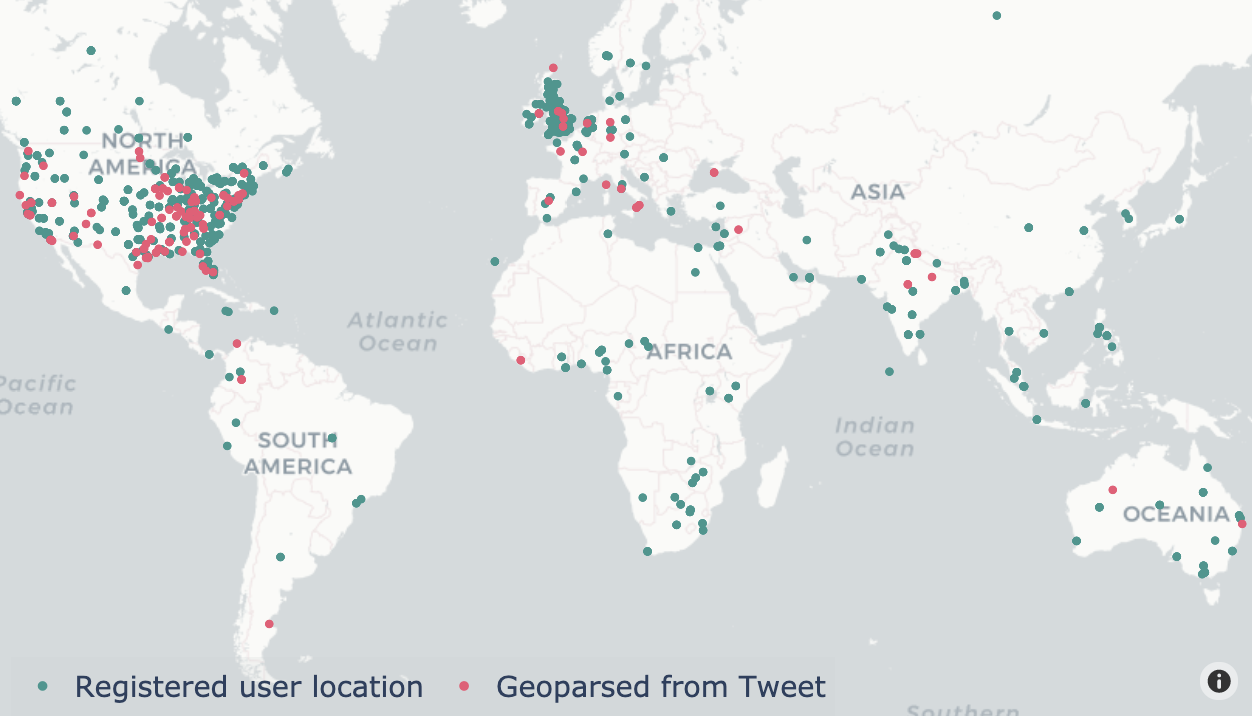

In [11]:
cols = ['#2C2CDB','#00E0E0']
scatter_map = px.scatter_mapbox(look2, lat="lat", lon="lon", color='Type', zoom=1, color_discrete_sequence=cols)
scatter_map.update_layout(mapbox_style="carto-positron", margin={"r":0,"t":0,"l":0,"b":0}, height=500,
                          legend=dict(bgcolor="rgba(203,210,211,0.2)", orientation="v", x=0.01, y=0, yanchor="bottom"))
scatter_map.show()

# Visualisation



In [ ]:
df = pd.read_csv('data/eng_labelled_tweets.csv') # final_tweets, final_coords_tweets

# filter only relevant tweets
geo_df = df[~df['geo'].isna()].reset_index(drop=True)
geo_df = geo_df[geo_df['relevant']==1].reset_index(drop=True)
for i in range(len(geo_df)):
    try: 
        geo_df['geo'][i] = eval(geo_df['geo'][i])
    except:
        geo_df['geo'][i] = geo_df['geo'][i]

#geo_df['coords'] = [geo_df['geo'][i]['coordinates'] for i in range(len(geo_df))]
geo_df['lat'] = [geo_df['geo'][i]['coordinates'][0] for i in range(len(geo_df))]
geo_df['lon'] = [geo_df['geo'][i]['coordinates'][1] for i in range(len(geo_df))]

#geo_df.to_csv('data/geo_tweets.csv',index=False)

## Folium
Leaflet, OpenStreetMap

In [ ]:
# base map
m = folium.Map([20.416775, -3.70379], tiles=None, zoom_start=2)

# tile layers
folium.TileLayer('cartodbpositron', show=True, name="light").add_to(m)
folium.TileLayer('cartodbdark_matter', show=False, name="dark").add_to(m)
folium.TileLayer('openstreetmap', show=False, name="color").add_to(m)

# add location marker cluster
mc = MarkerCluster(name='Tweets').add_to(m)

# create marker at locations
for lat, lon, user_location, full_text, created_at, retweet_count in zip(geo_df['lat'], geo_df['lon'], geo_df['user_location'], 
                                     geo_df['full_text'], geo_df['created_at'], geo_df['retweet_count']):
    text = folium.Html('Tweet: {}<br> User location: {}<br> Created at: {}<br> Retweet count: {}<br>'.format(full_text, user_location, created_at, retweet_count), script=True)
    popup = folium.Popup(text, max_width=300)
    folium.CircleMarker(location = [lat, lon],
                        radius = 2,
                        weight = 5,
                        color = '#081d58',
                        fill_color = '#081d58',
                        fill = True,
                        popup = popup,
                        tooltip = 'Click on Tweet'
                        ).add_to(mc)
mc.add_to(m)

# add layer control
folium.LayerControl('topright', collapsed=True).add_to(m)

m

## Kepler.gl

https://medium.com/nightingale/how-to-create-eye-catching-maps-with-python-and-kepler-gl-e7e897eff8ac

In [ ]:
viz_cols = ['lon','lat','created_at','full_text','user_location']
kepler_map = keplergl.KeplerGl(height=500)
kepler_map.add_data(data=geo_df[viz_cols], name="Extreme weather events")
#kepler_map.save_to_html(file_name="kepler_map.html")
kepler_map

## Plotly
Mapbox map

In [ ]:
# point map
scatter_map = px.scatter_mapbox(geo_df, lat="lat", lon="lon", hover_name="full_text", 
                        hover_data=["created_at", "user_location",'retweeted'],
                        color_discrete_sequence=["teal"], 
                        zoom=1, height=500)
scatter_map.update_layout(mapbox_style="carto-positron",margin={"r":0,"t":0,"l":0,"b":0})
scatter_map.show()

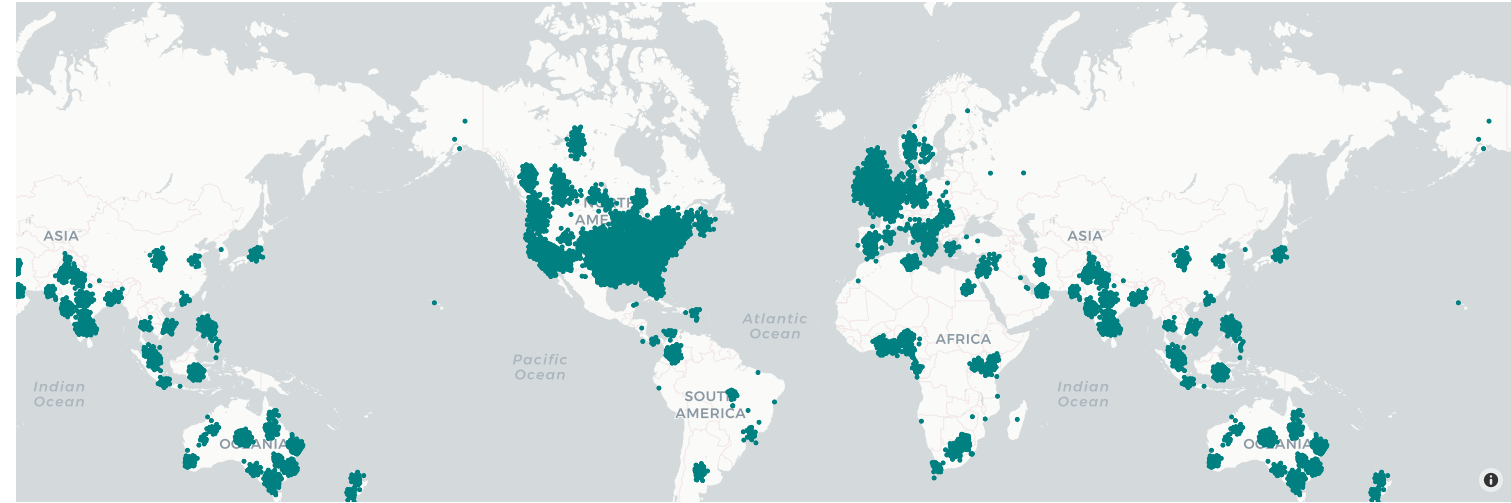

In [8]:
# size by retweet_count
scatter_map = px.scatter_mapbox(
    geo_df, lat="lat", lon="lon", 
    size = 'retweet_count',
    size_max = 15,
    color='retweeted',
    hover_data=['full_text'],
    #color_discrete_sequence=["teal",""],
    zoom=1, height=500)
scatter_map.update_layout(mapbox_style="dark",
                          margin={"r":0,"t":0,"l":0,"b":0})
scatter_map.show()


In [ ]:
hexabin_map = ff.create_hexbin_mapbox(data_frame=geo_df[['lat','lon']], lat="lat", lon="lon",
                                      nx_hexagon=25, opacity=0.5, labels={"color": "Relevant Tweets"},
                                      min_count=1, color_continuous_scale="Teal",
                                      show_original_data=True, height=500, zoom=0.95,
                                      original_data_marker=dict(size=5, opacity=0.7, color="Teal")
)
hexabin_map.update_layout(mapbox_style="carto-positron",
                          margin={"r":0,"t":0,"l":0,"b":0})
hexabin_map.show()

In [ ]:
# find number of tweets by date
df['Date'] = pd.to_datetime(df['created_at']).dt.date
count_dates = df.groupby('Date').size().values
time_df = df.drop_duplicates(subset="Date").assign(Count=count_dates)
time_df = time_df[['Date','Count']].sort_values(by='Date')

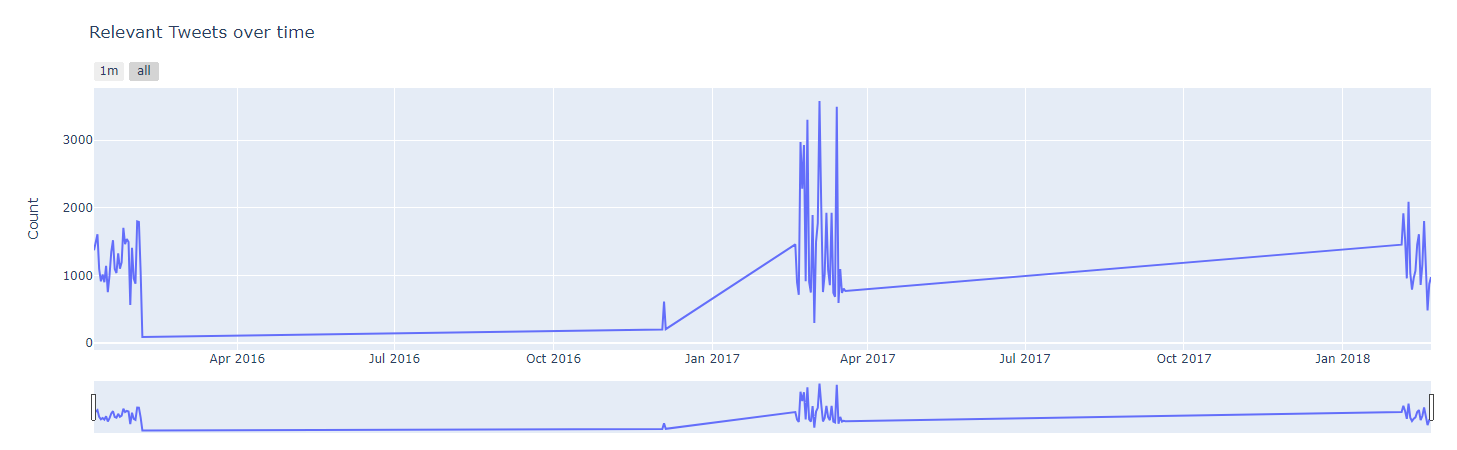

In [9]:
line_fig = px.line(time_df, x='Date', y='Count', title='Relevant Tweets over time')

line_fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            #dict(count=6, label="6m", step="month", stepmode="backward"),
            #dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
line_fig.show()


Treemap

In [ ]:
df = pd.read_csv('data/final_tweets.csv')
df.dropna(subset=['tokens'],inplace=True)
df['tokens'] = [literal_eval(s) for s in df['tokens']]

In [ ]:
token_list = df['hashtags'].tolist()
token_list = [token for sublist in token_list for token in sublist]

freq = FreqDist(token_list)
freq_df = pd.DataFrame(list(freq.items()), columns = ["Word","Occurrences"]) 
freq_df = freq_df[freq_df['Word']!=' ']
freq_df = freq_df[freq_df['Word']!='…']
freq_df = freq_df.sort_values('Occurrences',ascending=False)
freq_df[:20]

,Word,Occurrences
114,#flood,2478
25,#flooding,1863
46,#floods,1259
80,#water,396
220,#Flood,370
421,#floodaware,350
199,#WaterDamage,326
197,#damage,310
200,#Restoration,307
198,#leak,304


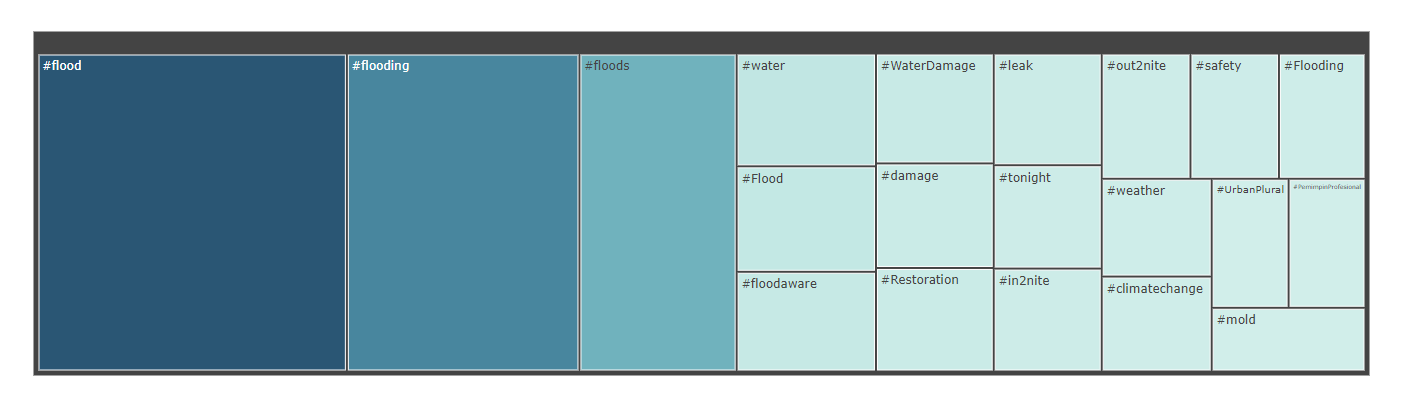

In [10]:
fig = go.Figure(go.Treemap(
    labels=freq_df['Word'][:20].tolist(),
    values=freq_df['Occurrences'][:20].tolist(),
    parents=['']*20,
    marker_colorscale=px.colors.sequential.Teal, # Burg, Darkmint, Mint, PuBu, Teal, YlGnBu, deep, ice, tempo
    hovertemplate='<b>%{label} </b> <br> Occurrences: %{value}<extra></extra>',
    pathbar={"visible": False},
))

fig.show()

## Dash

In [ ]:
df = pd.read_json('data/eng_merged.json',orient='split')
df.rename(columns={'relevant_LR':'Logistic regression','relevant_RF':'Random forest','relevant_CNN':'CNN','relevant_ULM':'ULMFiT'},inplace=True)
df = df[df['date'].dt.year>2016]
df.drop(['tweet_id','retweeted','tweet'], axis='columns', inplace=True)

In [ ]:
#df.to_json('data/eng_tweets_1718.json',orient="split")
df = pd.read_json('data/eng_tweets_1718.json',orient="split")
df.columns

In [ ]:
# Initiate app
app = JupyterDash(
    __name__, external_stylesheets=[dbc.themes.BOOTSTRAP],
    meta_tags=[{"name":"viewport","content":"width=device-width,initial-scale=1,maximum-scale=1.0,user-scalable=no"}]
)

server = app.server
app.config.suppress_callback_exceptions = True

app.run_server(mode='external', port=8060, use_reloader=False, debug=True)
#app._terminate_server_for_port("localhost", 8060)

https://github.com/s153748/extreme-weather-detection/blob/main/app.py

https://extremeweatherdetection.herokuapp.com/

# Evaluation of Pipeline

In this section we load the English unlabelled tweets 

## Unlabelled tweets

Load and clean unlabbeled tweets.
This was done for one year at a time.

In [ ]:
# load unlabelled tweets
years = ['2016','2017','2018']
year = years[0]

df1 = pd.read_json(f'Unlabbeled/eng_{year}.json', lines=True)

# add userinfo, tokens, retweet variables etc.
df2 = get_userinfo(df1)
df3 = get_tokens(df2)
df4 = add_vars(df3)

df_new=df4

# save to file
df_new.to_json('new.json',orient='split')

## Classify tweets

### Logistic Regression

In [ ]:
# load the model from disk

clf_LR = pickle.load(open('Classifiers/LR.sav', 'rb'))
LR_vocab =  pickle.load(open('Classifiers/LR_tfidf.sav', 'rb'))

transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=LR_vocab)
corpus = [' '.join(df_new['tokens'].iloc[i]) for i in range(len(df_new))]
tfidf = transformer.fit_transform(loaded_vec.fit_transform(corpus))

labels = clf_RF.predict(tfidf)

df_new['relevant_LR'] = labels
print('Relevant tweets:', df_new['relevant_LR'].sum()/len(df_new)*100, '%')

### Random Forest


In [ ]:
# load the model from disk

clf_RF = pickle.load(open('Classifiers/RF.sav', 'rb'))
RF_vocab=  pickle.load(open('Classifiers/RF_tfidf.sav', 'rb'))

transformer = TfidfTransformer()
loaded_vec = CountVectorizer(decode_error="replace",vocabulary=RF_vocab)
corpus = [' '.join(df_new['tokens'].iloc[i]) for i in range(len(df_new))]
tfidf = transformer.fit_transform(loaded_vec.fit_transform(corpus))

labels = clf_RF.predict(tfidf)
df_new['relevant_RF'] = labels
print('Relevant tweets:', df_new['relevant_RF'].sum()/len(df_new)*100, '%')

### CNN


In [ ]:
def predictions(df,model,tokenizer):

    #tokenizer.fit_on_texts(df['full_text'].tolist())
    sequences = tokenizer.texts_to_sequences(df['text_DL'])

    MAX_SEQUENCE_LENGTH  = 30
    new_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    predictions =model.predict_classes(new_data, batch_size=1024, verbose=1)

    prediction_labels =  [i[0] for i in predictions.tolist()]
            
    return  prediction_labels

In [ ]:
# load json and create model

json_file = open('Classifiers/CNN.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN = model_from_json(loaded_model_json)

# load tokenizer
json_file = open('Classifiers/CNN_tokenizer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
CNN_tokenizer = tokenizer_from_json(loaded_model_json)

# load weights into new model

CNN.load_weights("Classifiers/CNN.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
CNN.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])


# get labels
labels = predictions(df_new,CNN,CNN_tokenizer)
df_new['relevant_CNN'] = labels
print('Relevant tweets:', df_new['relevant_CNN'].sum()/len(df_new)*100, '%')

### Evaluation

In [ ]:
print('Tweets:',len(df_new))
print('Relevant tweets LR:', df_new['relevant_LR'].sum()/len(df_new)*100, '%')
print('Relevant tweets RF:', df_new['relevant_RF'].sum()/len(df_new)*100, '%')
print('Relevant tweets CNN:', df_new['relevant_CNN'].sum()/len(df_new)*100, '%')
print('Relevant tweets ULMFiT:', df_new['relevant_ULM'].sum()/len(df_new)*100, '%')

print(60*'_')

df_new['sum_relevance'] = df_new[['relevant_LR','relevant_RF','relevant_CNN','relevant_ULM']].sum(axis=1)

print('At least one:',(df_new['sum_relevance']>0).sum()/len(df_new)*100, '%') 
print('Relevant tweets from all classifiers:', (df_new['sum_relevance']==4).sum()/len(df_new)*100, '%')
print('Irrelevant tweets from all classifiers:', (df_new['sum_relevance']==0).sum()/len(df_new)*100, '%')

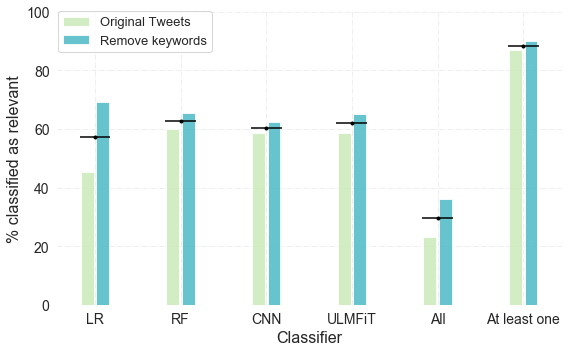

In [13]:
blues = ['#c7e9b4', '#41b6c4', '#225ea8']

rem = [69.1, 65.4, 62.3, 65.3, 36.0, 90.0]
org = [45.5, 60.1, 58.6, 58.6, 23.0, 86.9]

avg = [(i+j)/2 for (i, j) in zip(org, rem)]
width = 0.15
xlabs = ['LR', 'RF', 'CNN', 'ULMFiT', 'All', 'At least one']
x = np.arange(len(xlabs))
sns.set_style('whitegrid')
plt.figure(figsize=(8, 5), tight_layout=True)
plt.bar(x-0.09, org, width, label='Original Tweets', color=blues[0], alpha=0.8)
plt.bar(x+0.09, rem, width, label='Remove keywords', color=blues[1], alpha=0.8)
plt.plot(x, avg, ".", color='k', mfc='k')
plt.hlines(y=avg[0], xmin=-0.18, xmax=0.18, color='k')
plt.hlines(y=avg[1], xmin=1-0.18, xmax=1+0.18, color='k')
plt.hlines(y=avg[2], xmin=2-0.18, xmax=2+0.18, color='k')
plt.hlines(y=avg[3], xmin=3-0.18, xmax=3+0.18, color='k')
plt.hlines(y=avg[4], xmin=4-0.18, xmax=4+0.18, color='k')
plt.hlines(y=avg[5], xmin=5-0.18, xmax=5+0.18, color='k')
plt.xticks([0, 1, 2, 3, 4, 5], xlabs, fontsize=14)
plt.ylim([0, 100])
plt.yticks(fontsize=14)
plt.xlabel('Classifier', fontsize=16)
plt.ylabel("% classified as relevant", fontsize=16)
plt.grid(alpha=0.4, ls='-.')
plt.box(on=None)
plt.legend(fontsize=13, bbox_to_anchor=(-0.01, 1.025), loc='upper left', frameon=True, ncol=1)
plt.savefig('/Users/lisestyve/Desktop/comp_rel.png')
plt.show()

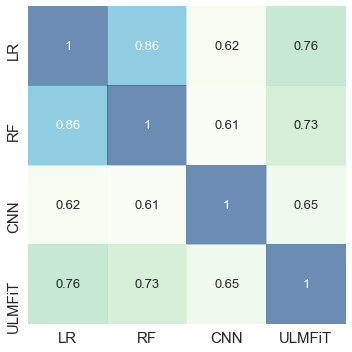

In [6]:
# Heatmap showing the similarity between the predictions made by the four classifiers for the variant ’Remove keywords’

LR =[1.000000,0.862731,0.620868,0.761818]
RF = [0.862731,1.000000,0.611390,0.730605]
CNN =[0.620868,0.611390,1.000000,0.645017]
ULM = [0.761818,0.730605,0.645017,1.000000]

df = pd.DataFrame(data={'Classifier':['LR','RF','CNN','ULMFiT'],
                        'LR': LR,
                        'RF': RF,
                        'CNN':CNN,
                        'ULMFiT':ULM})
df.set_index('Classifier',inplace=True)

sns.set_style('whitegrid')
plt.figure(figsize=(7, 5), tight_layout=True)
sns.heatmap(df, cmap="GnBu", alpha=0.6, square=True, annot=True, annot_kws={"size":13}, cbar=False)
plt.ylabel("", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Get location

In [ ]:
# get relevant tweets

df_rel = df_new[df_new['sum_relevance']!=0]
df_rel.drop(columns={'sum_relevance'},inplace=True)
print('Relevant tweets:',len(df_rel), '/', len(df_new))


# get geo coordinates
geo_df = df_rel[~df_rel['geo'].isna()]

#filter only relevant tweets
geo_df = geo_df[geo_df['relevant_CNN']==1].reset_index(drop=True)
geo_df['coords'] = [geo_df['geo'][i]['coordinates'] for i in range(len(geo_df))]

print('Geotagged tweets:',len(geo_df), '/', len(df_rel))


In [ ]:
Look_up, df_last, final_df = localization(df_rel)

### Evaluate

In [ ]:
val,count = np.unique(final_df['localization'],return_counts=True)
N = len(final_df)
print('Geotagged coordinates: ', count[0]/N*100, '%'  )
print('Geotagged place: ', count[1]/N*100, '%' )
print('Geoparsed from text: ', count[2]/N*100, '%'  )
print('Registered user location: ', count[3]/N*100, '%'  )
print('No location:', (1-N/df_rel)*100, '%')

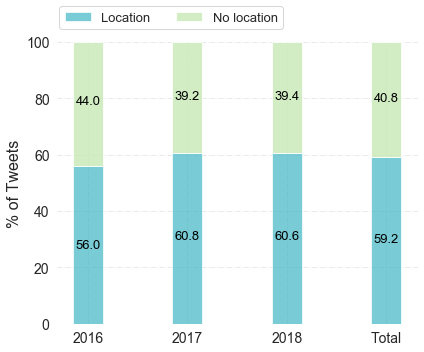

In [9]:
noloc = [44.05  ,  39.21 ,  39.37  , 40.83]
loc = [100-noloc[0],100-noloc[1],100-noloc[2],100-noloc[3]]
x = np.arange(4)
width = 0.3
xlabs = ['2016', '2017', '2018', 'Total']
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5), tight_layout=True)
plt.bar(x, loc, width, label='Location', color=blues[1], alpha=0.7)
plt.bar(x, noloc, width, label='No location', color=blues[0], alpha=0.8, bottom=loc)
plt.xticks([0, 1, 2, 3], xlabs, fontsize=14)
plt.ylim([0, 100])
plt.yticks(fontsize=14)
plt.ylabel("% of Tweets", fontsize=16)
plt.grid(alpha=0.5, ls='-.')
plt.box(on=None)
plt.legend(fontsize=13, bbox_to_anchor=(-0.01, 1.15), loc='upper left', frameon=True, ncol = 2)
for i in range(len(x)):
    plt.text(i, loc[i]//2, np.round(loc[i],1), ha = 'center', color='black', size=13)
    plt.text(i, loc[i]+noloc[i]//2, np.round(noloc[i],1), ha = 'center', color='black', size=13)
plt.show()

In [7]:
geo = [1.78, 1.05, 0.75, 1.19]
pla = [4.37, 3.92, 3.63, 3.97]
par = [20.27, 16.02, 17.27, 17.96]
reg = [73.58, 79.01, 78.35, 76.88]

print(geo[0]+pla[0]+par[0]+reg[0])
print(geo[1]+pla[1]+par[1]+reg[1])
print(geo[2]+pla[2]+par[2]+reg[2])
print(geo[3]+pla[3]+par[3]+reg[3])

#df = pd.DataFrame([geo,pla,par,reg],['Geotagged coordinates','Geotagged place','Geoparsed from Tweet','Registered user location'])
d = {'Year': ['2016', '2017', '2018', 'Total'], 'Geotagged coordinates': geo, 'Geotagged place': pla, 'Geoparsed from Tweet': par, 'Registered user location': reg}
df = pd.DataFrame(data=d)
df

100.0
100.0
100.0
100.0


,Year,Geotagged coordinates,Geotagged place,Geoparsed from Tweet,Registered user location
0,2016,1.78,4.37,20.27,73.58
1,2017,1.05,3.92,16.02,79.01
2,2018,0.75,3.63,17.27,78.35
3,Total,1.19,3.97,17.96,76.88


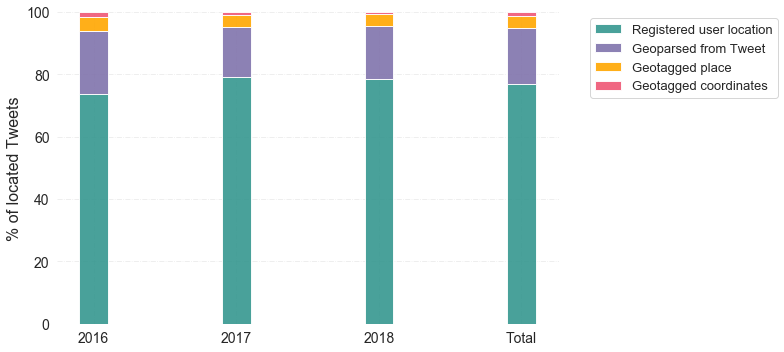

In [10]:
geo = np.array([1.78, 1.05, 0.75, 1.19])
pla = np.array([4.37, 3.92, 3.63, 3.97])
par = np.array([20.27, 16.02, 17.27, 17.96])
reg = np.array([73.58, 79.01, 78.35, 76.88])

colors = ['#ef5675','#ffa600','#8073ac','#35978f']
x = np.arange(4)
width = 0.2
xlabs = ['2016', '2017', '2018', 'Total']
sns.set_style('whitegrid')
plt.figure(figsize=(11, 5), tight_layout=True)
plt.bar(x, reg, width, label='Registered user location', color=colors[3], alpha=0.9)
plt.bar(x, par, width, label='Geoparsed from Tweet', color=colors[2], alpha=0.9, bottom=reg)
plt.bar(x, pla, width, label='Geotagged place', color=colors[1], alpha=0.9, bottom=reg+par)
plt.bar(x, geo, width, label='Geotagged coordinates', color=colors[0], alpha=0.9, bottom=reg+par+pla)
plt.xticks([0, 1, 2, 3], xlabs, fontsize=14)
plt.ylim([0, 100])
plt.yticks(fontsize=14)
plt.ylabel("% of located Tweets", fontsize=16)
plt.grid(alpha=0.4, ls='-.')
plt.box(on=None)
plt.legend(fontsize=13, bbox_to_anchor=(1.05, 1.0), loc='upper left', frameon=True, ncol = 1)
plt.show()

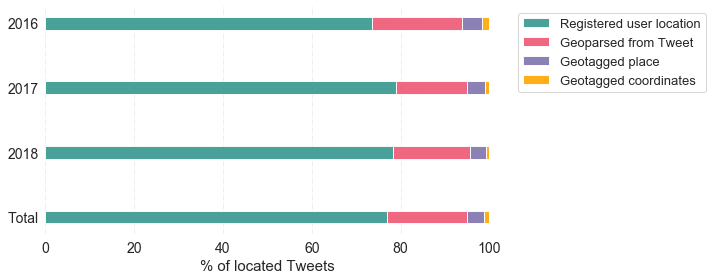

In [11]:
plt.figure(figsize=(10, 4), tight_layout=True)
plt.barh(x, reg, width, label='Registered user location', color=colors[3], alpha=0.9)
plt.barh(x, par, width, label='Geoparsed from Tweet', color=colors[0], alpha=0.9, left=reg)
plt.barh(x, pla, width, label='Geotagged place', color=colors[2], alpha=0.9, left=reg+par)
plt.barh(x, geo, width, label='Geotagged coordinates', color=colors[1], alpha=0.9, left=reg+par+pla)
plt.yticks([0, 1, 2, 3], xlabs, fontsize=14)
plt.xlim([0, 100])
plt.xticks(fontsize=14)
#plt.ylabel("Year", fontsize=16)
plt.xlabel("% of located Tweets", fontsize=15)
plt.gca().invert_yaxis()
plt.grid(alpha=0.4, ls='-.')
plt.box(on=None)
plt.legend(fontsize=13, bbox_to_anchor=(1.05, 1.0), loc='upper left', frameon=True, ncol = 1)
plt.show()